# Project - Machine Learning

<font color="red"> 

<font color="blue"> Shanshan Jiang </font>

# I. Introduction

In this project, three machine learning methods are used to classify land cover types and extract path-shaped objects. The experiments are implemented in image level, pixel level and texture level. 



python packages needed:
    geos, shapely, geojson, tifffile, descartes

# II. Data



## 2.1 data description

Data name:<br>
Dstl Satellite Imagery<br>

Data inroduction: <br>
Dstl provides you with 1km x 1km satellite images in both 3-band and 16-band formats. There are two types of imagery spectral content provided in this competition. The 3-band images are the traditional RGB natural color images. The 16-band images contain spectral information by capturing wider wavelength channels. This multi-band imagery is taken from the multispectral (400 – 1040nm) and short-wave infrared (SWIR) (1195-2365nm) range. All images are in GeoTiff format and might require GeoTiff viewers (such as QGIS) to view[1]. 


Data labels:<br>
The land cover classes: Buildings, Manmade structures, Road, Track, Trees, Crops, Waterway, Standing water, Vehicle Large, Vehicle Small 
 


Understanding multispectral bands:<br>
Sensor : WorldView 3<br>
Panchromatic: 450-800nm<br>
8 multispectral:<br>
coastal: 400-450nm<br>
blue: 450 - 510nm<br>
green: 510 - 580 nm<br>
yellow: 585 -625 nm<br>
red: 630 - 690nm<br>
red edge: 705 - 745nm<br>
near- IR1: 770 - 895nm<br>
near -IR2: 860-1040nm<br>

8 SWIR bands:<br>
SWIR-1: 1195 - 1225nm<br>
SWIR-2: 1550 - 1590nm<br>
SWIR - 3: 1640 - 1680nm<br>
SWIR -4: 1710 - 1750nm<br>
SWIR - 5: 2145-2185nm<br>
SWIR-6:2185-2225nm<br>
SWIR-7: 2235-2285nm<br>
SWIR-8: 2295-2365nm<br>

Sensor Resolution (GSD) at Nadir:<br>
Panchromatic: 0.31m <br>
Multispectral: 1.24m <br>
SWIR: Delivered at 7.5m<br>
Dynamic Range:<br>
Panchromatic and multispectral : 11-bits per pixel<br>
SWIR : 14-bits per pixel<br>


What can we do with SWIR bands:<br>
Each object has its own spectral signature, which is also the basic principle of remote sensing [2].SWIR is immediate adjacent to NIR in electromagnetic spectrum and refers to non-visible light falling roughly between 1400 and 3000 nanometers (nm) in wavelength [2].
Panchromatic sensor capture imagery in single band (black and white film) instead of collecting visible color (red, green, blue) separately, it combines them into one channel or band. Panchromatic sensor can see more light at once and can have very high spatial resolutions (31 cm in WorldView 3) than any other sensor types. But panchromatic sensor cannot see in night and through smoke.SWIR sensor may not have similar spatial resolution but they have a high spatial resolution (3.7/7.5 meter in WorldView 3, 30 m in Landsat 8). SWIR sensor can see in night and through smoke [2].
Near Infrared sensor are extremely important for ecology because healthy plants reflect it – the water in their leaves scatters the wavelengths back into the sky. They can be used for vegetation monitoring, crop stress etc. By comparing it with other bands, we get indexes like NDVI, which let us measure plant health more precisely than if we only looked at visible greenness. But NIR sensor do not tell us about the geology, rocks etc.
SWIR sensors are particularly useful for telling wet earth from dry earth, and for geology: rocks and soils that look similar in other bands often have strong contrasts in SWIR. SWIR sensors discriminates moisture content of soil and vegetation and penetrates thin clouds[2].




In this experiment, images from multispectral and SWIR, combinging with RGB image were used.

## 2.2 data preprocessing and visualization


In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

First, the 3 band RGB map was visualized.

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1dcbc4f5e48>)

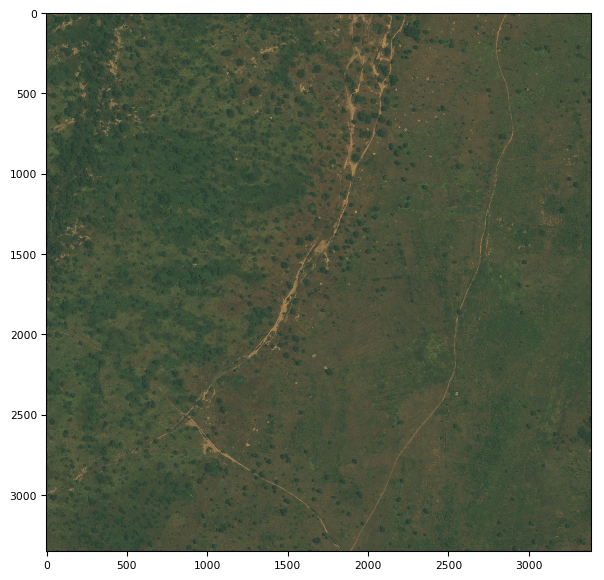

In [2]:
#https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection#data-processing-tutorial
#read geo tiff
import tifffile as tiff
#rgb
img_ind = '6170_2_4'
img_filename_3band = 'data/three_band/'+img_ind+'.tif'


Irgb = tiff.imread(img_filename_3band)

tiff.imshow(Irgb)




In [3]:
Irgb.shape

(3, 3349, 3389)

In [4]:
np.max(Irgb)

766

Second, 16 band spectual image was visualized.<br>
Panchromatic: 450-800 nm <br>
8 Multispectral: (red, red edge, coastal, blue, green, yellow, near-IR1 and near-IR2) 400 nm - 1040 nm <br>
8 SWIR: 1195 nm - 2365 nm

A Bands shape: (8, 134, 135)
M Bands shape: (8, 837, 848)
P Bands shape: (3348, 3392)


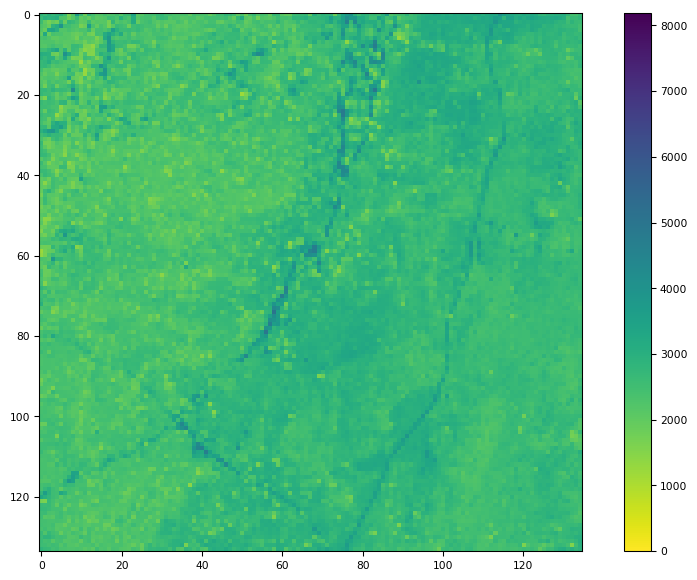

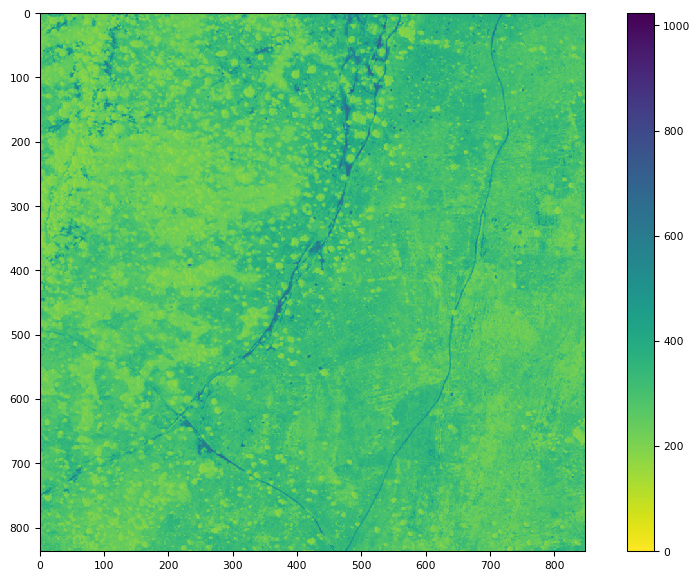

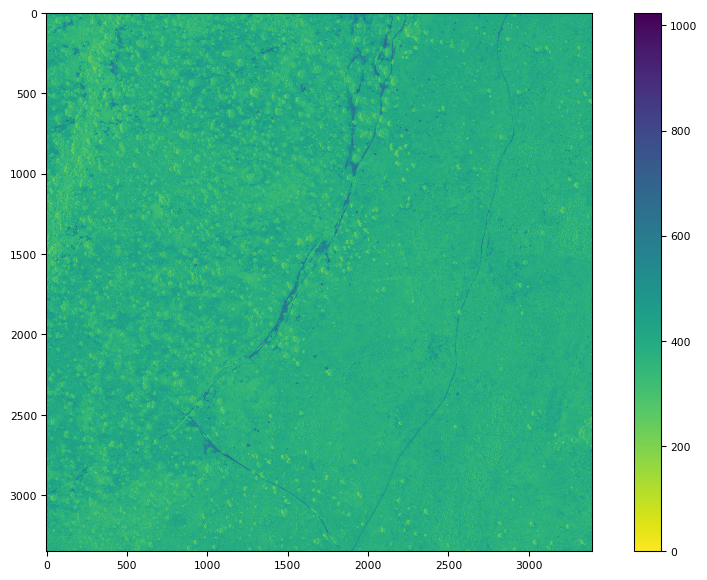

In [5]:
#spectual
%matplotlib inline
I16bandA = 'data/sixteen_band/'+img_ind+'_A.tif'
I16bandM = 'data/sixteen_band/'+img_ind+'_M.tif'
I16bandP = 'data/sixteen_band/'+img_ind+'_P.tif'

P1 = tiff.imread(I16bandA)
P2 = tiff.imread(I16bandM)
P3 = tiff.imread(I16bandP)
tiff.imshow(P1[2])
tiff.imshow(P2[4])
tiff.imshow(P3)#because P3 has only one channel
print('A Bands shape:', P1.shape)
print('M Bands shape:', P2.shape)
print('P Bands shape:', P3.shape)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x1dcc40e4f60>)

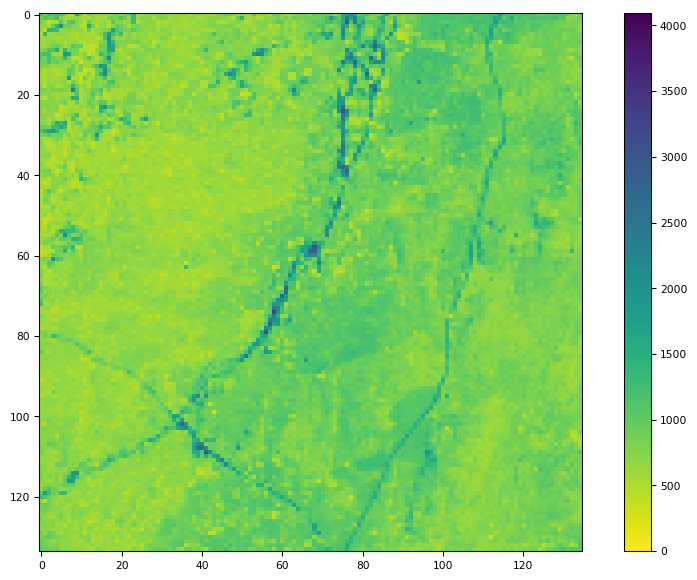

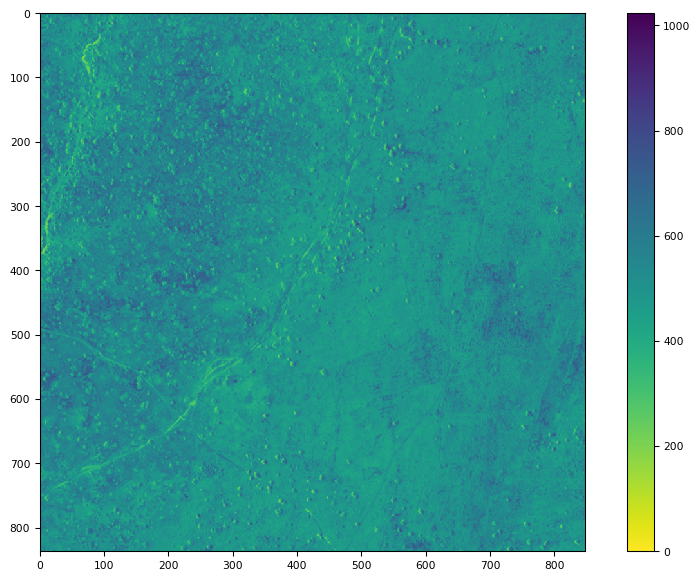

In [6]:
tiff.imshow(P1[7])
tiff.imshow(P2[7])

Next we will see how to display the labels (polygons).

In [15]:
#code reference#https://www.kaggle.com/visoft/export-pixel-wise-mask/code
#https://www.kaggle.com/amanbh/visualize-polygons-and-image-data/code
import pandas as pd
import cv2
from shapely.wkt import loads as wkt_loads
from matplotlib.patches import Polygon, Patch


In [16]:
labelpoly = pd.read_csv('data/train_wkt_v4.csv')
print(labelpoly.head())

    ImageId  ClassType                                    MultipolygonWKT
0  6040_2_2          1                                 MULTIPOLYGON EMPTY
1  6040_2_2          2                                 MULTIPOLYGON EMPTY
2  6040_2_2          3                                 MULTIPOLYGON EMPTY
3  6040_2_2          4  MULTIPOLYGON (((0.003025 -0.007879000000000001...
4  6040_2_2          5  MULTIPOLYGON (((0.005311 -0.009044999999999999...


meaning of grid.csv<br>
ImageId - ID of the image<br>
Xmax - maximum X coordinate for the image<br>
Ymin - minimum Y coordinate for the image<br>

In [17]:
gs = pd.read_csv('data/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
print(gs)

      ImageId      Xmax      Ymin
0    6120_2_4  0.009180 -0.009040
1    6120_2_3  0.009169 -0.009040
2    6120_2_2  0.009188 -0.009040
3    6120_2_1  0.009188 -0.009040
4    6120_2_0  0.009188 -0.009040
5    6180_2_4  0.009169 -0.009031
6    6180_2_1  0.009169 -0.009042
7    6180_2_0  0.009156 -0.009042
8    6180_2_3  0.009188 -0.009040
9    6180_2_2  0.009188 -0.009040
10   6180_0_3  0.009188 -0.009040
11   6180_0_2  0.009169 -0.009040
12   6180_0_1  0.009156 -0.009042
13   6180_0_0  0.009169 -0.009040
14   6180_0_4  0.009180 -0.009040
15   6080_4_4  0.009007 -0.009037
16   6080_4_2  0.009150 -0.009042
17   6080_4_3  0.009180 -0.009040
18   6080_4_0  0.009188 -0.009040
19   6080_4_1  0.009016 -0.009037
20   6090_4_1  0.009188 -0.009040
21   6090_4_0  0.009158 -0.009043
22   6090_4_3  0.009188 -0.009040
23   6090_4_2  0.009188 -0.009040
24   6090_4_4  0.009156 -0.009042
25   6180_4_4  0.009188 -0.009040
26   6180_4_3  0.009169 -0.009040
27   6180_4_2  0.009161 -0.009042
28   6180_4_1 

In [18]:
xmax, ymin = gs[gs.ImageId == img_ind].iloc[0,1:].astype(float)
W, H = Irgb.shape[1:]
print(xmax)
print(ymin)
print(W)
print(H)

0.00915030000001
-0.00904230000001
3349
3389


In [19]:
trainImageIds = labelpoly.ImageId.unique() #all the training image id labeled
trainImageIds

array(['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3',
       '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1',
       '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2',
       '6110_3_1', '6010_4_4', '6170_2_4', '6170_4_1', '6170_0_4',
       '6060_2_3', '6070_2_3', '6010_1_2', '6040_4_4', '6100_2_2'],
      dtype=object)

In [20]:
df_image = labelpoly[labelpoly.ImageId == img_ind]
df_image.ClassType

170     1
171     2
172     3
173     4
174     5
175     6
176     7
177     8
178     9
179    10
Name: ClassType, dtype: int64

In [21]:
df_image

ImageId  ClassType                                    MultipolygonWKT
170  6170_2_4          1                                 MULTIPOLYGON EMPTY
171  6170_2_4          2  MULTIPOLYGON (((0.001147 -0.005895, 0.001148 -...
172  6170_2_4          3                                 MULTIPOLYGON EMPTY
173  6170_2_4          4  MULTIPOLYGON (((0.0004612722772277231 -0.00799...
174  6170_2_4          5  MULTIPOLYGON (((0.000187 -0.009042, 0.000186 -...
175  6170_2_4          6  MULTIPOLYGON (((0.004918 -0.009042, 0.001751 -...
176  6170_2_4          7                                 MULTIPOLYGON EMPTY
177  6170_2_4          8  MULTIPOLYGON (((0.000128 -0.003404, 0.000138 -...
178  6170_2_4          9                                 MULTIPOLYGON EMPTY
179  6170_2_4         10                                 MULTIPOLYGON EMPTY

class info:<br>
1. Buildings - large building, residential, non-residential, fuel storage facility, fortified building
2. Misc. Manmade structures 
3. Road 
4. Track - poor/dirt/cart track, footpath/trail
5. Trees - woodland, hedgerows, groups of trees, standalone trees
6. Crops - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops
7. Waterway 
8. Standing water
9. Vehicle Large - large vehicle (e.g. lorry, truck,bus), logistics vehicle
10. Vehicle Small - small vehicle (car, van), motorbike

In [22]:
#code ref:https://www.kaggle.com/gabrielaltay/polygons-over-images-and-5x5-mosaics/code
def get_clip_values(img, percentile_max=99.99):#99.99% < vmax and 0.01%> vmax
        print('finding clip values')
        vmin = img[img!=0].min()
        vmax = np.percentile(img, percentile_max)
        return vmin, vmax
def normalize_image(img):
        print('normalizing pixel values to range (0,1)')
        img = (img - img.min()) / (img.max() - img.min())
        return img

In [23]:
img = normalize_image(Irgb[0])
print(img.shape)
vmin, vmax = get_clip_values(img)
extent = [0.0, xmax, ymin, 0.0]


normalizing pixel values to range (0,1)
(3349, 3389)
finding clip values


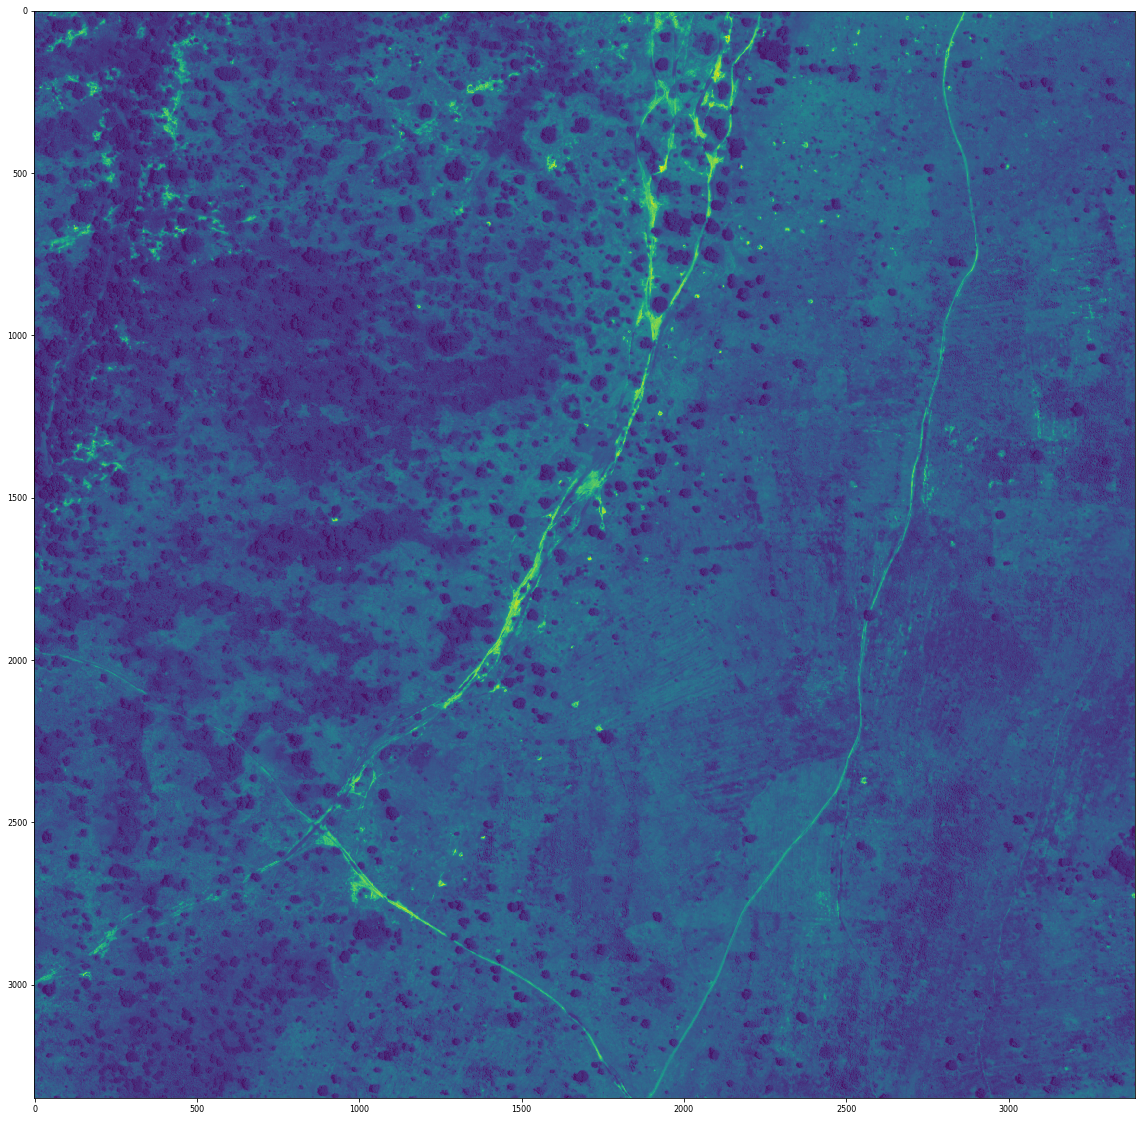

In [24]:
plt.figure(figsize = (20,20))
plt.imshow(img)

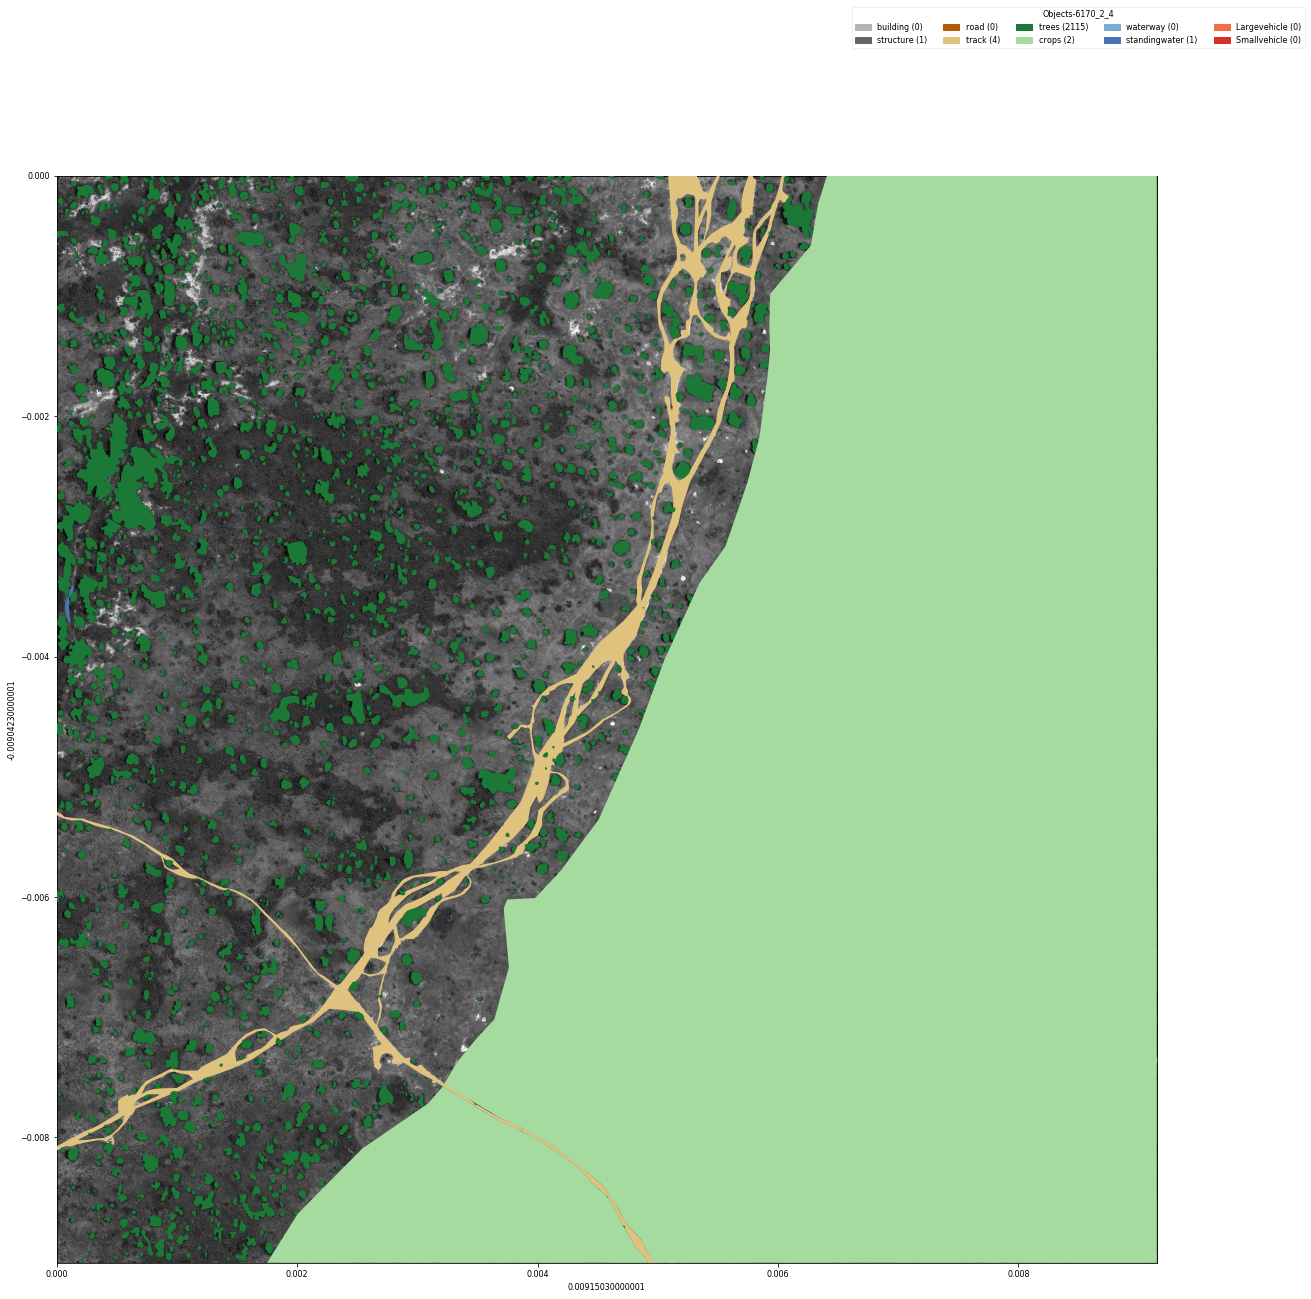

In [25]:
#code reference: https://www.kaggle.com/amanbh/visualize-polygons-and-image-data/code
from matplotlib import cm
from descartes.patch import PolygonPatch
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(img,cmap=cm.gray, vmin=vmin, vmax=vmax, extent=extent)

polygonsList = {}
typename = ['building','structure', 'road','track','trees','crops','waterway','standingwater','Largevehicle','Smallvehicle']
COLORS = ['0.7','0.4','#b35806','#dfc27d','#1b7837','#a6dba0','#74add1','#4575b4','#f46d43','#d73027']
ZORDER = [1,2,3,4,5,6,7,8,9,10]
legend_patches=[]
for cType in range(10):    
    polygonsList[cType] = wkt_loads(df_image[df_image.ClassType == cType+1].MultipolygonWKT.values[0])
    legend_patches.append(Patch(color=COLORS[cType],label='{} ({})'.format(typename[cType], len(polygonsList[cType]))))
    #legend_patches = plot_polygons(fig, ax, polygonsList)
    for polygon in polygonsList[cType]:
            mpl_poly = PolygonPatch(polygon,
                                    color=COLORS[cType],
                                    lw=0,
                                    alpha=1,
                                    zorder=ZORDER[cType])
            ax.add_patch(mpl_poly)

ax.set_xlim(0, xmax)
ax.set_ylim(ymin, 0)
ax.set_xlabel(xmax)
ax.set_ylabel(ymin)

ax.legend(handles=legend_patches,
                   # loc='upper center',
                   bbox_to_anchor=(1, 1),
                   bbox_transform=plt.gcf().transFigure,
                   ncol=5,
                   #fontsize='x-small',
                   title='Objects-' + img_ind,
                   # mode="expand",
                   framealpha=0.3)


In [26]:
COLORS[0]

'0.7'

From the figure above, we can see this image contains manmade structure, track, trees, crops, standing water. The trees ocupies most space.

# III Method

Deep learning method is adopted to train a model to classify landcover. It is hard to label all the pixels for geo images. The dtsl dataset provides 25 land cover images to train, and each image has a large size, e.g. 837*848 for band M. U-net is a good method to process cases with few samples but large image size [6].  

## 3.1 U-net architecture

The two-class U-NET architecture is shown as the image from [6] below: <br>
**Left branch:** In the left side of the U shape, it is just normal image convolution operations. Each convolution is followed by a ReLU activation function and max pooling. Data channels (indicating number of filters) are doubled at the downsampling step.<br>
**Right branch:** In the right side of the U shape,instead of down sampling, up-convolution is used to recover image information. And especially, a image with same same from left side is concatenated with current data. A successive convolution layer can then learn to assemble a more precise output [6].The network does not have any fully connected layers and only uses the valid part of each convolution enables the seamless segmentation of arbitrarily large images by an overlap-tile strategy [6].<br>
Patches are used to solve the few training sample problem.<br>
When we process multi-class problem, a simple way using a U-NET is to generate multi classifiers.

![title](unet.jpg)

## 3.2 Training

A deep learning framework for U-net is introduced in [6]. In this framework, training images are from band M. Only one epoch is used to train in the code implementation. Here, we use 10 epochs. As this training takes about 24 fours, the training code will not display in this notebook. If you are interested, you can run it using script.py in the project folder.

Here we listed the 10 epoch training result:<br>
Train on 3506 samples, validate on 1058 samples<br>
Epoch 1/10<br>
3506/3506 [==============================] - 7776s 2s/step - loss: 0.2573 - jaccard_coef: 0.0461 - jaccard_coef_int: 0.0197 - acc: 0.9023 - val_loss: 0.1932 - val_jaccard_coef: 0.0486 - val_jaccard_coef_int: 0.0575 - val_acc: 0.9153<br>
Epoch 2/10
3506/3506 [==============================] - 7434s 2s/step - loss: 0.1822 - jaccard_coef: 0.0539 - jaccard_coef_int: 0.0253 - acc: 0.9234 - val_loss: 0.1774 - val_jaccard_coef: 0.0621 - val_jaccard_coef_int: 0.0117 - val_acc: 0.9251<br>
Epoch 3/10
3506/3506 [==============================] - 7366s 2s/step - loss: 0.1672 - jaccard_coef: 0.0777 - jaccard_coef_int: 0.0681 - acc: 0.9327 - val_loss: 0.1635 - val_jaccard_coef: 0.0819 - val_jaccard_coef_int: 0.0762 - val_acc: 0.9376<br>
Epoch 4/10
3506/3506 [==============================] - 7355s 2s/step - loss: 0.1614 - jaccard_coef: 0.0865 - jaccard_coef_int: 0.0817 - acc: 0.9344 - val_loss: 0.1564 - val_jaccard_coef: 0.0955 - val_jaccard_coef_int: 0.1001 - val_acc: 0.9367<br>
Epoch 5/10
3506/3506 [==============================] - 7322s 2s/step - loss: 0.1514 - jaccard_coef: 0.1024 - jaccard_coef_int: 0.1057 - acc: 0.9397 - val_loss: 0.1521 - val_jaccard_coef: 0.1013 - val_jaccard_coef_int: 0.0477 - val_acc: 0.9286<br>
Epoch 6/10
3506/3506 [==============================] - 7378s 2s/step - loss: 0.1476 - jaccard_coef: 0.1100 - jaccard_coef_int: 0.1083 - acc: 0.9411 - val_loss: 0.1487 - val_jaccard_coef: 0.1123 - val_jaccard_coef_int: 0.1107 - val_acc: 0.9423<br>
Epoch 7/10
3506/3506 [==============================] - 7329s 2s/step - loss: 0.1445 - jaccard_coef: 0.1174 - jaccard_coef_int: 0.1095 - acc: 0.9448 - val_loss: 0.1660 - val_jaccard_coef: 0.0840 - val_jaccard_coef_int: 0.0724 - val_acc: 0.9391<br>
Epoch 8/10
3506/3506 [==============================] - 7381s 2s/step - loss: 0.1512 - jaccard_coef: 0.0993 - jaccard_coef_int: 0.0970 - acc: 0.9401 - val_loss: 0.1471 - val_jaccard_coef: 0.1118 - val_jaccard_coef_int: 0.1075 - val_acc: 0.9429<br>
Epoch 9/10<>
3506/3506 [==============================] - 8466s 2s/step - loss: 0.1420 - jaccard_coef: 0.1166 - jaccard_coef_int: 0.1099 - acc: 0.9449 - val_loss: 0.1451 - val_jaccard_coef: 0.1141 - val_jaccard_coef_int: 0.1055 - val_acc: 0.9473<br>
Epoch 10/10
3506/3506 [==============================] - 7859s 2s/step - loss: 0.1374 - jaccard_coef: 0.1220 - jaccard_coef_int: 0.1108 - acc: 0.9484 - val_loss: 0.1377 - val_jaccard_coef: 0.1186 - val_jaccard_coef_int: 0.1194 - val_acc: 0.9495<br>


In [3]:
val_acc_list = [0.9153,0.9251,0.9376,0.9286,0.9423,0.9391,0.9429,0.9473,0.9495]

Let us visualize the training accuracy on validation samples. 

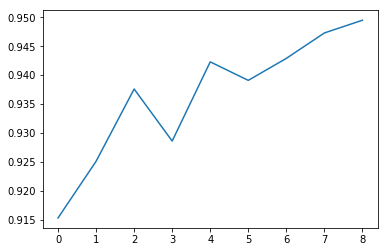

In [7]:
import matplotlib.pyplot as plt
plt.plot(val_acc_list)
plt.show()

Then let us visualize the data prediction result for validation dataset. 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict


In [13]:
#code ref: https://www.kaggle.com/alijs1/squeezed-this-in-successful-kernel-run/code
N_Cls = 10
ISZ = 160
smooth = 1e-12
def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)
def get_unet():
    inputs = Input((8, ISZ, ISZ))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(N_Cls, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model
def calc_jacc(model):
    img = np.load('data/x_tmp_%d.npy' % N_Cls)
    msk = np.load('data/y_tmp_%d.npy' % N_Cls)

    prd = model.predict(img, batch_size=4)
    print (prd.shape, msk.shape)
    avg, trs = [], []
    acctr = np.zeros((N_Cls, 10))

    for i in range(N_Cls):
        t_msk = msk[:, i, :, :]
        t_prd = prd[:, i, :, :]
        t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])

        m, b_tr = 0, 0
        for j in range(10):#find best threshold
            tr = j / 10.0
            pred_binary_mask = t_prd > tr

            jk = jaccard_similarity_score(t_msk, pred_binary_mask)
            acctr[i][j]=jk
            if jk > m:
                m = jk
                b_tr = tr
        print (i, m, b_tr)#(class,acc,threshold)
        avg.append(m)
        trs.append(b_tr)

    score = sum(avg) / 10.0
    return score, trs,acctr

In [14]:
model = get_unet()
model.load_weights('data/weights/unet_10_jk0.7344')
avgacc, threshold, acctr=calc_jacc(model)

C:\Users\ssjia\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
C:\Users\ssjia\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
C:\Users\ssjia\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
C:\Users\ssjia\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
C:\Users\ssjia\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="relu")`
C:\Users\ssjia\Anaconda3\envs

(1058, 10, 160, 160) (1058, 10, 160, 160)
0 0.781452644102861 0.5
1 0.624078158053155 0.3
2 0.8218572778827977 0.6
3 0.38489484877126656 0.5
4 0.2168345496957447 0.2
5 0.6682695099266336 0.5
6 0.9482797015562457 0.8
7 0.965335538752363 0.5
8 0.9889591209829868 0.4
9 0.943773629489603 0.4


In [18]:
acctr[0]

array([0.08138325, 0.65682252, 0.72511278, 0.76315471, 0.77827719,
       0.78145264, 0.77848927, 0.77170121, 0.76105908, 0.74436872])

In [28]:
acclist = acctr.tolist()
len(acclist)

10

Best threshold selection:

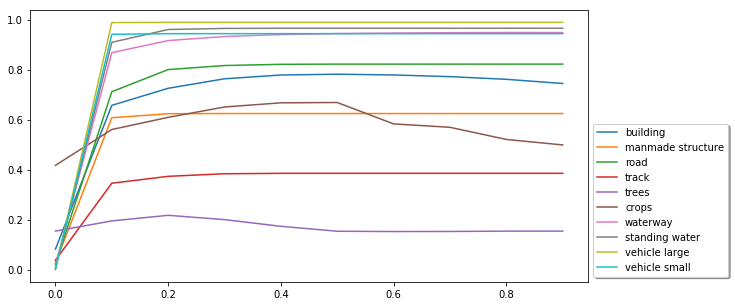

In [55]:
#code ref:https://matplotlib.org/users/pyplot_tutorial.html
plt.figure(figsize=(10,5))
t = np.arange(0., 1., 0.1)
color = ['r','g','b','c','m','y','k','purple','pink','orange']
classname = ['building','manmade structure','road','track','trees','crops','waterway','standing water','vehicle large','vehicle small']
for accl,c,name in zip(acclist,color,classname):
    plt.plot(t,accl,label=name)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.6),shadow=True, fontsize=10)
plt.show()

Now we extract the validation accuracy and best threshold found for each classifier.
Format: class, accuracy, best threshold.

0 0.781452644102861 0.5<br>
1 0.624078158053155 0.3<br>
2 0.8218572778827977 0.6<br>
3 0.38489484877126656 0.5<br>
4 0.2168345496957447 0.2<br>
5 0.6682695099266336 0.5<br>
6 0.9482797015562457 0.8<br>
7 0.965335538752363 0.5<br>
8 0.9889591209829868 0.4<br>
9 0.943773629489603 0.4<br>


In [65]:
inDir = './data'
#ref: https://www.kaggle.com/drn01z3/end-to-end-baseline-with-u-net-keras __author__ = "n01z3"

def stretch_n(bands, lower_percent=5, higher_percent=95):#normalize
    out = np.zeros_like(bands)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)

def predict_id(id, model, trs):
    img = M(id)
    x = stretch_n(img)

    cnv = np.zeros((960, 960, 8)).astype(np.float32)
    prd = np.zeros((N_Cls, 960, 960)).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = x

    for i in range(0, 6):
        line = []
        for j in range(0, 6):
            line.append(cnv[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ])

        x = 2 * np.transpose(line, (0, 3, 1, 2)) - 1
        tmp = model.predict(x, batch_size=4)
        for j in range(tmp.shape[0]):
            prd[:, i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ] = tmp[j]

    
    for i in range(N_Cls):
        prd[i] = prd[i] > trs[i]

    return prd[:, :img.shape[0], :img.shape[1]]



In [118]:
id = '6170_2_4'
trs = [0.5, 0.3, 0.6, 0.5, 0.2, 0.5, 0.8, 0.5, 0.4, 0.4]
res=predict_id(id, model, trs)
img = M(id)
x = stretch_n(img)

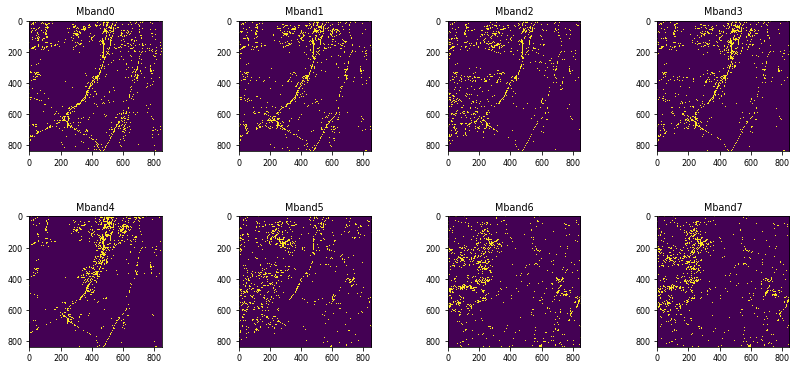

In [119]:
fig, axs = plt.subplots(2,4, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(8):
    axs[i].imshow(x[:,:,i])
    axs[i].set_title('Mband'+str(i))

plt.show()


In [120]:
res.shape

(10, 837, 848)

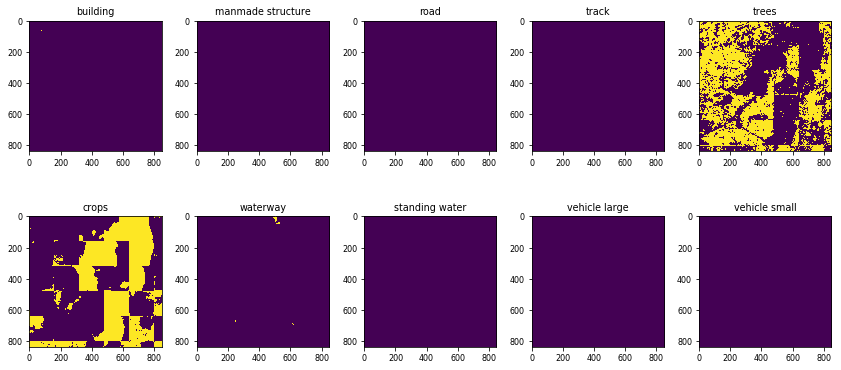

In [121]:
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(10):
    axs[i].imshow(res[i,:,:])
    axs[i].set_title(classname[i])

plt.show()

Extract masks for training data

In [33]:
import os
N_Cls = 10
inDir = './data'
DF = pd.read_csv(inDir + '/train_wkt_v4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
ISZ = 160
smooth = 1e-12


def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int


def _get_xmax_ymin(grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)


def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, class_type)
    return mask


In [162]:
Irgbnew.shape

(3, 837, 848)

In [35]:
id = '6170_2_4'
maskimg=generate_mask_for_image_and_class((P1.shape[1],P1.shape[2]),id,4)

In [36]:
np.max(maskimg)

4

In [37]:
maskimg.shape

(134, 135)

In [38]:
np.max(maskimg)

4

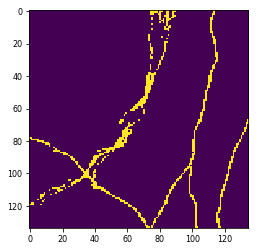

In [39]:
plt.imshow(maskimg)

## Superpixel

In [131]:
from skimage.segmentation import slic
from skimage.data import astronaut
img = astronaut()
segments = slic(img, n_segments=100, compactness=10)

In [154]:
img

array([[[0.60392157, 0.57647059, 0.59215686],
        [0.24705882, 0.22745098, 0.4       ],
        [0.29803922, 0.29803922, 0.41568627],
        ...,
        [0.49411765, 0.47058824, 0.43921569],
        [0.49411765, 0.47058824, 0.44705882],
        [0.47058824, 0.45882353, 0.41568627]],

       [[0.78823529, 0.76078431, 0.75686275],
        [0.65882353, 0.64705882, 0.64313725],
        [0.65490196, 0.64705882, 0.63137255],
        ...,
        [0.49019608, 0.45882353, 0.43529412],
        [0.49019608, 0.46666667, 0.44313725],
        [0.49411765, 0.45490196, 0.43921569]],

       [[0.90980392, 0.8745098 , 0.8745098 ],
        [0.86666667, 0.84313725, 0.82352941],
        [0.86666667, 0.82745098, 0.83529412],
        ...,
        [0.50196078, 0.4627451 , 0.44313725],
        [0.47843137, 0.45490196, 0.40784314],
        [0.48627451, 0.4627451 , 0.43137255]],

       ...,

       [[0.73333333, 0.65490196, 0.69411765],
        [0.73333333, 0.65882353, 0.68627451],
        [0.72941176, 0

In [134]:
segments.shape

(512, 512)

In [158]:
Irgb.shape
Irgb1 =np.moveaxis(Irgb, 0, 2)
Irgb1.shape

(3349, 3389, 3)

In [159]:
Irgb1 = normalize_image(Irgb1)

normalizing pixel values to range (0,1)


SLIC number of segments: 226


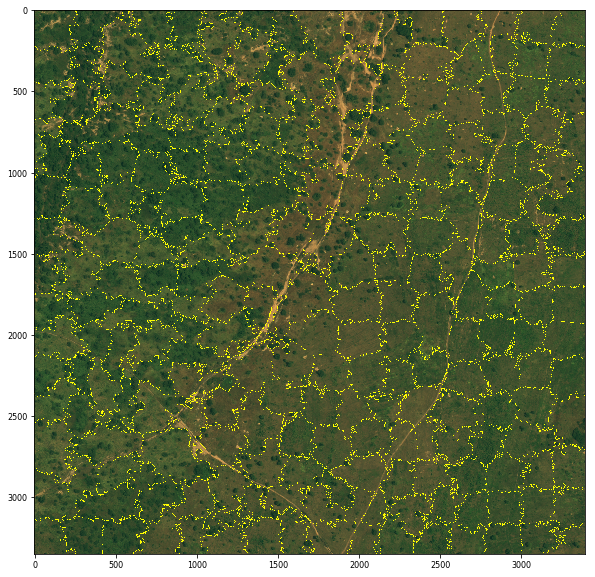

In [162]:
##http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

segments_slic = slic(Irgb1, n_segments=250, compactness=10, sigma=1)

print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))


plt.figure(figsize=(10, 10))


plt.imshow(mark_boundaries(Irgb1, segments_slic))




plt.show()

In [ ]:
segments_slic = slic(Irgb1, n_segments=500, compactness=5, sigma=1)

print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))


plt.figure(figsize=(10, 10))


plt.imshow(mark_boundaries(Irgb1, segments_slic))




plt.show()

## image training data as point

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict
from skimage.transform import resize
import itertools
from sklearn.metrics import confusion_matrix

C:\Users\ssjia\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [28]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def normalize_image(img):
    print('normalizing pixel values to range (0,1)')
    img = (img - img.min()) / (img.max() - img.min())
    return img.astype(np.float32)

def resize_img(img,size,mode='channel_last'):
    if len(img.shape)>2 and mode == 'channel_first':
        img1 = np.moveaxis(img, 0, 2)
        r = resize(img1, size)
        rimg = np.moveaxis(r, 2, 0)
    else:
        rimg = resize(img, size)
        
    return rimg.astype(np.float32)

class image():
    def __init__(self, inDir = './data/',sizeto='A'):
        self.N_Cls = 10
        self.traininfo = pd.read_csv(inDir + 'train_wkt_v4.csv')
        self.traincoor = pd.read_csv(inDir + 'grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)#coordinates
        self.threebandloc = inDir + 'three_band/'
        self.sixteenbandloc = inDir + 'sixteen_band/'
        self.trainImageIds = None
        self.maxrow = None
        self.maxcol = None
        self.Irgb = None
        self.I16bandA = None
        self.I16bandM = None
        self.I16bandP = None 
        self.Irgbnew = None
        self.I16bandAnew = None
        self.I16bandMnew = None
        self.I16bandPnew = None 
        self.xmax = None
        self.ymin = None
        self.mask = None
        self.para = sizeto
        self.maskdict = None
        self.classind = {'0':'background','1':'building','2':'manmade structure','3':'road',
                          '4':'track','5':'trees','6':'crops','7':'waterway',
                          '8':'standing water','9':'vehicle large','10':'vehicle small'}
        self.classorder = [6,5,1,2,3,4,7,8,9,10]
    def resize_to_resolution(self, para = 'rgb'):
        if self.Irgb.shape[0] == 3: 
            thismode = 'channel_first'
        else:
            thismode = 'channel_last'
        if (para == 'rgb'):#best resolution
            row = self.Irgb.shape[1]
            col = self.Irgb.shape[2]
        if (para == 'A'):#smallest 
            row = self.I16bandA.shape[1]
            col = self.I16bandA.shape[2]
        if (para == 'M'):#medium
            row = self.I16bandM.shape[1]
            col = self.I16bandM.shape[2]

        self.I16bandPnew = resize_img(self.I16bandP,size =(row,col),mode=thismode)
        self.I16bandAnew = resize_img(self.I16bandA,size =(row,col),mode=thismode)
        self.I16bandMnew = resize_img(self.I16bandM,size =(row,col),mode=thismode)
        self.Irgbnew = resize_img(self.Irgb,size =(row,col),mode=thismode)
        return
    def _convert_coordinates_to_raster(self,coords, img_size, xymax):
        # __author__ = visoft
        # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        Xmax, Ymax = xymax
        H, W = img_size
        W1 = 1.0 * W * W / (W + 1)
        H1 = 1.0 * H * H / (H + 1)
        xf = W1 / Xmax
        yf = H1 / Ymax
        coords[:, 1] *= yf
        coords[:, 0] *= xf
        coords_int = np.round(coords).astype(np.int32)
        return coords_int
    def _get_xmax_ymin(self, imgid):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        xmax, ymin = self.traincoor[self.traincoor.ImageId == imgid].iloc[0, 1:].astype(float)
        return (xmax, ymin)
   
    def _get_polygon_list(self,imageId, cType):
        # __author__ = visoft
        # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        df_image = self.traininfo[self.traininfo.ImageId == imageId]
        multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
        polygonList = None
        if len(multipoly_def) > 0:
            assert len(multipoly_def) == 1
            polygonList = wkt_loads(multipoly_def.values[0])
        return polygonList
    
    def _get_and_convert_contours(self,polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        perim_list = []
        interior_list = []
        if polygonList is None:
            return None
        for k in range(len(polygonList)):
            poly = polygonList[k]
            perim = np.array(list(poly.exterior.coords))
            perim_c = self._convert_coordinates_to_raster(perim, raster_img_size, xymax)
            perim_list.append(perim_c)
            for pi in poly.interiors:
                interior = np.array(list(pi.coords))
                interior_c = self._convert_coordinates_to_raster(interior, raster_img_size, xymax)
                interior_list.append(interior_c)
        return perim_list, interior_list
    
    def _plot_mask_from_contours(self,raster_img_size, contours, class_value=1):
        # __author__ = visoft
        # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        #self.mask = np.zeros(raster_img_size, np.uint8)
        if contours is None:
            return
        perim_list, interior_list = contours
        cv2.fillPoly(self.mask, perim_list, class_value)
        cv2.fillPoly(self.mask, interior_list, 0)
        return 
    
    def generate_mask_for_image_and_class(self,raster_size, imageId, class_type):
        # __author__ = visoft
        # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        xymax = self._get_xmax_ymin(imageId)
        polygon_list =self. _get_polygon_list(imageId, class_type)
        contours = self._get_and_convert_contours(polygon_list, raster_size, xymax)
        self._plot_mask_from_contours(raster_size, contours, class_type)
        return 
    def reset_imgset(self):
        self.Irgb = None
        self.I16bandA = None
        self.I16bandM = None
        self.I16bandP = None
        self.Irgbnew = None
        self.I16bandAnew = None
        self.I16bandMnew = None
        self.I16bandPnew = None
        self.mask = None
        
    def get_trainimg_id(self):
        self.trainImageIds = self.traininfo.ImageId.unique() #all the training image id labeled
        return
    def _normalize_img(self):
        self.Irgb = normalize_image(self.Irgb)
        self.I16bandA = normalize_image(self.I16bandA)
        self.I16bandM = normalize_image(self.I16bandM)
        self.I16bandP = normalize_image(self.I16bandP)
        return
 
    def read_train_oneimg(self,imgid):   
        #read rgb       
        self.reset_imgset()
        self.Irgb = tiff.imread(self.threebandloc+imgid+'.tif')#shape(3,3349,3389)
        self.I16bandA = tiff.imread(self.sixteenbandloc+imgid+'_A.tif')#8band
        self.I16bandM = tiff.imread(self.sixteenbandloc+imgid+'_M.tif')#8band
        self.I16bandP = tiff.imread(self.sixteenbandloc+imgid+'_P.tif')#1band
        self.maxrow = self.Irgb.shape[1]
        self.maxcol = self.Irgb.shape[2]
        self._normalize_img()
        self.resize_to_resolution(para = self.para)
        raster_img_size = ((self.Irgbnew.shape[1],self.Irgbnew.shape[2]))
        self.mask = np.zeros(raster_img_size, np.uint8)
        #self.generate_mask_for_image_and_class(raster_img_size, imgid, 6)
        
        for class_type in self.classorder:
            #print("get mask of type:"+str(class_type))
            self.generate_mask_for_image_and_class(raster_img_size, imgid, class_type)
        return

In [29]:
myimg = image(sizeto = 'A')
columnname=['I3band1', 'I3band2', 'I3band3',
                            'IAband1','IAband2','IAband3','IAband4',
                            'IAband5','IAband6','IAband7','IAband8',
                            'IMband1','IMband2','IMband3','IMband4',
                            'IMband5','IAband6','IAband7','IAband8',
                            'IP','class']
myimg.get_trainimg_id()
df = pd.DataFrame(columns=columnname)
for imgid in myimg.trainImageIds:
    print(imgid)
    myimg.read_train_oneimg(imgid)
    Imask = myimg.mask
    #plt.imshow(Imask)
    
    Irgbnew = myimg.Irgbnew
    I3band1 = Irgbnew[0].flatten()[:,np.newaxis]
    I3band2 = Irgbnew[1].flatten()[:,np.newaxis]
    I3band3 = Irgbnew[2].flatten()[:,np.newaxis]
    Iall= np.hstack((I3band1,I3band2,I3band3))
    IA =myimg.I16bandAnew
    IM =myimg.I16bandMnew
    IP =myimg.I16bandPnew
    for i in range(8):
        IAband = IA[i].flatten()[:,np.newaxis]
        Iall= np.hstack((Iall,IAband))
    for i in range(8):
        IMband = IM[i].flatten()[:,np.newaxis]
        Iall= np.hstack((Iall,IMband))   
    IPband = IP.flatten()[:,np.newaxis]
    Iall= np.hstack((Iall,IPband))
    Iclass = Imask.flatten()[:,np.newaxis]
    Iall= np.hstack((Iall,Iclass)) 
    df2 = pd.DataFrame(Iall, columns=columnname)
    
    df=df.append(df2, ignore_index=True)
    
df['class'] = df['class'].astype(np.int32)

6040_2_2
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)


C:\Users\ssjia\Anaconda3\envs\py35\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


6120_2_2
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
6120_2_0
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
6090_2_0
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
6040_1_3
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
6040_1_0
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
6100_1_3
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values t

In [43]:
df

I3band1   I3band2   I3band3   IAband1   IAband2   IAband3   IAband4  \
0       0.258913  0.521048  0.197411  0.465933  0.638627  0.551625  0.482966   
1       0.257642  0.525594  0.200971  0.446541  0.612683  0.534329  0.466981   
2       0.211371  0.510738  0.182810  0.444444  0.603512  0.527254  0.466195   
3       0.258575  0.525706  0.193386  0.408543  0.530922  0.452568  0.395440   
4       0.155358  0.430446  0.140139  0.422694  0.567610  0.487159  0.422432   
5       0.195075  0.488395  0.178895  0.513103  0.696017  0.604822  0.523585   
6       0.234789  0.513581  0.180748  0.384172  0.500524  0.419549  0.361897   
7       0.092251  0.381883  0.121383  0.529874  0.708595  0.634958  0.556342   
8       0.318966  0.602317  0.222094  0.459906  0.623166  0.533805  0.475629   
9       0.228625  0.521914  0.190970  0.420073  0.557652  0.491876  0.425839   
10      0.218403  0.512886  0.184495  0.428721  0.541929  0.481656  0.404088   
11      0.235476  0.533993  0.196647  0.429507  0.559748  0.468553  0.408805   
12      0.155933  0.462817  0.161267  0.426101  0.549790  0.480870  0.430818   
13      0.241340  0.523574  0.193830  0.521488  0.688679  0.604298  0.525681   
14      0.298163  0.586188  0.213996  0.485849  0.650157  0.578616  0.504717   
15      0.265443  0.553564  0.203884  0.433962  0.568920  0.508386  0.437369   
16      0.246069  0.533499  0.179217  0.462264  0.597746  0.514937  0.450472   
17      0.274124  0.559927  0.210390  0.513365  0.627883  0.540618  0.476677   
18      0.205229  0.495787  0.175456  0.468029  0.631551  0.557390  0.474581   
19      0.207697  0.498019  0.184482  0.460954  0.628669  0.541143  0.483229   
20      0.223762  0.513873  0.187928  0.456499  0.612945  0.534329  0.458857   
21      0.324816  0.595303  0.219057  0.460954  0.584906  0.507600  0.427411   
22      0.190896  0.488631  0.153733  0.469078  0.607442  0.528302  0.452568   
23      0.183107  0.474008  0.161127  0.448113  0.586740  0.506551  0.427411   
24      0.218900  0.511395  0.174789  0.562893  0.751048  0.655136  0.602725   
25      0.357566  0.628399  0.226331  0.588574  0.704140  0.634172  0.532233   
26      0.327739  0.584148  0.200662  0.663522  0.836216  0.724843  0.632600   
27      0.498852  0.741580  0.278860  0.645440  0.846698  0.740304  0.645964   
28      0.347917  0.629492  0.231836  0.531184  0.694444  0.584906  0.513103   
29      0.211176  0.472991  0.165215  0.471960  0.615566  0.519654  0.443658   
...          ...       ...       ...       ...       ...       ...       ...   
454900  0.036675  0.121978  0.071155  0.169698  0.125504  0.133561  0.100964   
454901  0.044409  0.124148  0.072898  0.175803  0.116103  0.121841  0.093212   
454902  0.038104  0.119255  0.072272  0.180076  0.128067  0.138078  0.103345   
454903  0.047928  0.126672  0.074887  0.184898  0.132401  0.141619  0.107374   
454904  0.034930  0.111815  0.068003  0.193322  0.134172  0.140825  0.104261   
454905  0.039695  0.121254  0.071673  0.208338  0.132768  0.139238  0.102674   
454906  0.023324  0.091904  0.064609  0.208155  0.140337  0.150470  0.112440   
454907  0.034211  0.113475  0.068891  0.190880  0.114394  0.123001  0.092663   
454908  0.029325  0.104371  0.066715  0.222867  0.133500  0.143755  0.109144   
454909  0.035148  0.105852  0.069210  0.207667  0.120010  0.132524  0.094311   
454910  0.038167  0.115258  0.070248  0.151447  0.101392  0.108900  0.083567   
454911  0.015958  0.085603  0.060096  0.189781  0.118240  0.127274  0.094372   
454912  0.026151  0.101439  0.065131  0.203882  0.114089  0.125320  0.089000   
454913  0.026955  0.094816  0.065075  0.192040  0.116591  0.122085  0.083567   
454914  0.032417  0.108810  0.066669  0.192528  0.123306  0.132951  0.095349   
454915  0.033612  0.112069  0.067792  0.181052  0.108290  0.116286  0.086803   
454916  0.039790  0.102427  0.069253  0.171469  0.109266  0.111952  0.081614   
454917  0.029702  0.102410  0.066107  0.186607  0.116958  0.124771  0.093151   
454918  0

In [ ]:
df["class"].value_counts()

We can see the data is very imbalanced.<br>
**Let us split the data to training data and test data shared by all methods.**

In [30]:
traindf = df.sample(frac=0.8,random_state=200)
validatedf = df.drop(traindf.index)

In [31]:
validateX = validatedf.values[:,:20]
validateY = validatedf.values[:,20]

In [32]:
traindf['class'].value_counts()

0     162160
5     100465
6      55314
4      18421
2      10701
1       7900
3       4068
7       2551
8       1282
10       991
9         91
Name: class, dtype: int64

In [33]:
validatedf['class'].value_counts()

0     40461
5     25012
6     13961
4      4602
2      2647
1      2002
3      1062
7       644
8       318
10      249
9        28
Name: class, dtype: int64

In [34]:
columnname= df.columns.tolist()
columnname

['I3band1',
 'I3band2',
 'I3band3',
 'IAband1',
 'IAband2',
 'IAband3',
 'IAband4',
 'IAband5',
 'IAband6',
 'IAband7',
 'IAband8',
 'IMband1',
 'IMband2',
 'IMband3',
 'IMband4',
 'IMband5',
 'IAband6',
 'IAband7',
 'IAband8',
 'IP',
 'class']

In [35]:
X = traindf.values[:,:20]
Y = traindf.values[:,20]

### downsampling

In [36]:

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(return_indices=True)
X_resampled, Y_resampled, idx_resampled = rus.fit_sample(X, Y)

In [37]:
Y_resampled=Y_resampled[:,np.newaxis]
Y_resampled.shape

(1001, 1)

In [38]:
downdata = np.hstack((X_resampled,Y_resampled))
print(downdata.shape)
downdf = pd.DataFrame(data=downdata)
downdf.columns= columnname
downdf['class'] = downdf['class'].astype(np.int32)
downdf

(1001, 21)


I3band1   I3band2   I3band3   IAband1   IAband2   IAband3   IAband4  \
0     0.339524  0.589715  0.214865  0.600891  0.738470  0.647537  0.557390   
1     0.357974  0.469153  0.082094  0.683889  0.727927  0.667975  0.565729   
2     0.442614  0.593503  0.171752  0.823612  0.901616  0.819161  0.702506   
3     0.272255  0.333562  0.229819  0.283674  0.327657  0.301313  0.258170   
4     0.306437  0.565054  0.161551  0.533351  0.710597  0.612426  0.530124   
5     0.258824  0.480637  0.130637  0.568049  0.660810  0.580464  0.504568   
6     0.443975  0.613684  0.176030  0.645784  0.829919  0.735588  0.645784   
7     0.340278  0.242436  0.036527  0.447915  0.385162  0.342351  0.280435   
8     0.040560  0.117644  0.070327  0.186302  0.118789  0.129288  0.100659   
9     0.227183  0.294638  0.186933  0.645812  0.491998  0.509250  0.388277   
10    0.343250  0.622440  0.202820  0.475515  0.601546  0.529381  0.451289   
11    0.127225  0.102627  0.040501  0.235489  0.307893  0.262379  0.230180   
12    0.418129  0.583434  0.148616  0.587966  0.730543  0.637672  0.559189   
13    0.514787  0.650521  0.174515  0.656856  0.835622  0.705036  0.628297   
14    0.200980  0.456425  0.107843  0.547875  0.690694  0.599516  0.509145   
15    0.407937  0.570317  0.265523  0.712438  0.777561  0.714393  0.684013   
16    0.029095  0.091191  0.070318  0.321101  0.196997  0.219850  0.148457   
17    0.249580  0.568218  0.187027  0.378351  0.532732  0.461340  0.394330   
18    0.145393  0.207564  0.133131  0.239787  0.219146  0.220494  0.176150   
19    0.343606  0.397656  0.261829  0.505803  0.589875  0.534667  0.494808   
20    0.235536  0.311536  0.174117  0.744708  0.516779  0.553175  0.403459   
21    0.346256  0.603753  0.242669  0.473270  0.630503  0.551363  0.500786   
22    0.196340  0.442865  0.116220  0.513448  0.631253  0.549489  0.446477   
23    0.332345  0.533400  0.241343  0.754098  0.840728  0.751241  0.698902   
24    0.052791  0.127360  0.077792  0.143633  0.096508  0.094982  0.074472   
25    0.174278  0.129201  0.050055  0.310330  0.410495  0.358803  0.323558   
26    0.240305  0.574341  0.189645  0.384536  0.520103  0.459278  0.385567   
27    0.215185  0.144943  0.048851  0.335014  0.408489  0.363031  0.314212   
28    0.034527  0.098350  0.074238  0.186489  0.111593  0.109425  0.080567   
29    0.196938  0.239550  0.145707  0.205042  0.280308  0.253144  0.204188   
...        ...       ...       ...       ...       ...       ...       ...   
971   0.153536  0.087472  0.015170  0.248490  0.297922  0.258461  0.223494   
972   0.267919  0.184493  0.070094  0.356340  0.457309  0.397416  0.351776   
973   0.127067  0.176261  0.109591  0.158833  0.202723  0.184532  0.148639   
974   0.136113  0.190117  0.115955  0.242889  0.329996  0.306922  0.252106   
975   0.140924  0.186672  0.129924  0.105653  0.126110  0.117903  0.091811   
976   0.080713  0.174446  0.118725  0.296585  0.342675  0.302777  0.269582   
977   0.250532  0.144155  0.037420  0.270538  0.336259  0.286196  0.249754   
978   0.223240  0.127671  0.033768  0.354023  0.430909  0.379020  0.332046   
979   0.156785  0.226985  0.152786  0.350844  0.387148  0.337523  0.320263   
980   0.122609  0.177467  0.119208  0.208583  0.261445  0.247772  0.199060   
981   0.229868  0.125017  0.031307  0.234658  0.295605  0.252633  0.218368   
982   0.146520  0.089916  0.015900  0.298554  0.367294  0.322076  0.270748   
983   0.113385  0.168879  0.117213  0.192101  0.243621  0.219326  0.176352   
984   0.201580  0.289274  0.173977  0.272199  0.314970  0.277178  0.254963   
985   0.270833  0.132783  0.030792  0.257759  0.315826  0.286687  0.245892   
986   0.178774  0.104457  0.020066  0.309156  0.356340  0.307050  0.262674   
987   0.213271  0.119802  0.029537  0.244980  0.311052  0.256074  0.237186   
988   0.166451  0.098580  0.020753  0.337593  0.437158  0.374877  0.335065   
989   0.144184  0.191122  0.137544  0.124150  0.156061  0.150058  0.119863   
990   0.252770  0.145904  0.0

In [39]:
downdf["class"].value_counts()

10    91
9     91
8     91
7     91
6     91
5     91
4     91
3     91
2     91
1     91
0     91
Name: class, dtype: int64

### over sampling

In [58]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, Y_resampled = ros.fit_sample(X, Y)
Y_resampled=Y_resampled[:,np.newaxis]
overdata = np.hstack((X_resampled,Y_resampled))
overdata.shape
overdf = pd.DataFrame(data=overdata)
overdf.columns= columnname
overdf['class'] = overdf['class'].astype(np.int32)
overdf

I3band1   I3band2   I3band3   IAband1   IAband2   IAband3   IAband4  \
0        0.292885  0.550127  0.163459  0.554061  0.704949  0.612964  0.524476   
1        0.600626  0.357401  0.091343  0.679543  0.802259  0.707433  0.603682   
2        0.465240  0.336183  0.111893  0.639247  0.651884  0.612542  0.522651   
3        0.462672  0.579015  0.141981  0.681273  0.744495  0.702202  0.580336   
4        0.522697  0.636559  0.282006  0.751842  0.845691  0.752444  0.719808   
5        0.414010  0.224523  0.049901  0.675610  0.851434  0.721564  0.640502   
6        0.257335  0.318761  0.192064  0.583021  0.666041  0.605535  0.551126   
7        0.287328  0.574275  0.215653  0.420335  0.536950  0.460168  0.378931   
8        0.275571  0.319002  0.190452  0.572796  0.666323  0.602158  0.547467   
9        0.275963  0.328537  0.194209  0.550281  0.669606  0.606285  0.558255   
10       0.195030  0.391007  0.085756  0.624971  0.670649  0.615601  0.499649   
11       0.180987  0.299830  0.169340  0.767682  0.494063  0.522974  0.384357   
12       0.399348  0.516196  0.103686  0.653804  0.785917  0.692392  0.608677   
13       0.089648  0.153788  0.109582  0.175844  0.130581  0.136890  0.094874   
14       0.240796  0.133652  0.035800  0.379652  0.481042  0.423325  0.370524   
15       0.254068  0.305635  0.175254  0.558638  0.425423  0.428768  0.327037   
16       0.237010  0.329023  0.185353  0.597131  0.385246  0.385451  0.291189   
17       0.494159  0.668024  0.222437  0.666508  0.850881  0.746308  0.653883   
18       0.354813  0.501979  0.125040  0.692610  0.834096  0.743623  0.652060   
19       0.220716  0.255569  0.165163  0.718121  0.632421  0.635261  0.494579   
20       0.087049  0.146399  0.114223  0.157040  0.099161  0.108593  0.075948   
21       0.171663  0.256747  0.194305  0.365837  0.421426  0.383552  0.350794   
22       0.483391  0.744282  0.252078  0.655460  0.848037  0.752286  0.659225   
23       0.049632  0.117682  0.081585  0.303253  0.211676  0.221685  0.162469   
24       0.151820  0.273916  0.170605  0.570697  0.367418  0.382787  0.276025   
25       0.309925  0.175590  0.052285  0.324322  0.410827  0.356130  0.317371   
26       0.232293  0.488269  0.161579  0.493481  0.539729  0.481181  0.416482   
27       0.538233  0.660069  0.197676  0.700676  0.856987  0.744277  0.659472   
28       0.222140  0.152010  0.060992  0.386215  0.496040  0.445218  0.387347   
29       0.245692  0.299359  0.181656  0.574015  0.643152  0.565009  0.525985   
...           ...       ...       ...       ...       ...       ...       ...   
1783730  0.150359  0.194710  0.136303  0.108471  0.117842  0.105469  0.086360   
1783731  0.241317  0.141071  0.036422  0.242101  0.296798  0.251088  0.220124   
1783732  0.147871  0.202181  0.136267  0.131364  0.157124  0.140032  0.112868   
1783733  0.054718  0.116163  0.078516  0.139177  0.173910  0.155048  0.124710   
1783734  0.122327  0.202345  0.125260  0.355697  0.426428  0.389275  0.348484   
1783735  0.113385  0.168879  0.117213  0.192101  0.243621  0.219326  0.176352   
1783736  0.042772  0.135571  0.108524  0.415385  0.383677  0.360600  0.302251   
1783737  0.280217  0.137790  0.033299  0.249403  0.299466  0.261550  0.221668   
1783738  0.187440  0.120863  0.033249  0.263797  0.327623  0.279034  0.249544   
1783739  0.050595  0.125565  0.078241  0.106641  0.113967  0.106275  0.072824   
1783740  0.117437  0.095167  0.029156  0.173706  0.199552  0.168243  0.134132   
1783741  0.162781  0.202691  0.140163  0.140442  0.176272  0.154652  0.121455   
1783742  0.271355  0.162058  0.051999  0.327342  0.414338  0.352268  0.317933   
1783743  0.079415  0.167251  0.130861  0.307974  0.353096  0.317824  0.296904   
1783744  0.167903  0.208060  0.142667  0.138789  0.180621  0.162859  0.129724   
1783745  0.205094  0.248340  0.160109  0.180437  0.231518  0.218656  0.172414   
1783746  0.355046  0.235699  0.086943  0.237256  0.314282  0.260567  0.237326   
1783747  0.206403  0.271787  0.173037  0.

In [59]:
overdf["class"].value_counts()

10    162160
9     162160
8     162160
7     162160
6     162160
5     162160
4     162160
3     162160
2     162160
1     162160
0     162160
Name: class, dtype: int64

### training without processing of imbalance using logit

In [126]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X, Y)
validatePre = logreg.predict(validateX)


In [46]:
classname = ['background','building','manmade structure','road','track','trees','crops','waterway','standing water','vehicle large','vehicle small']

[[30022    21     6     2     1  6929  3459    15     6     0     0]
 [ 1870    18     0     9     0    18    81     6     0     0     0]
 [ 2342    12     0     0     0    69   221     1     2     0     0]
 [  978     1     0    16     0    32    33     2     0     0     0]
 [ 3457     3     1     2     0   289   849     1     0     0     0]
 [10303     0     0     2     0 13349  1352     2     4     0     0]
 [ 7042     0     0     0     0   979  5938     0     2     0     0]
 [  297     0     0     0     1    16     1   329     0     0     0]
 [  184     0     0     6     0    26    14     2    86     0     0]
 [   27     0     0     1     0     0     0     0     0     0     0]
 [  243     1     0     0     0     0     5     0     0     0     0]]
Confusion matrix, without normalization
[[30022    21     6     2     1  6929  3459    15     6     0     0]
 [ 1870    18     0     9     0    18    81     6     0     0     0]
 [ 2342    12     0     0     0    69   221     1     2     0 

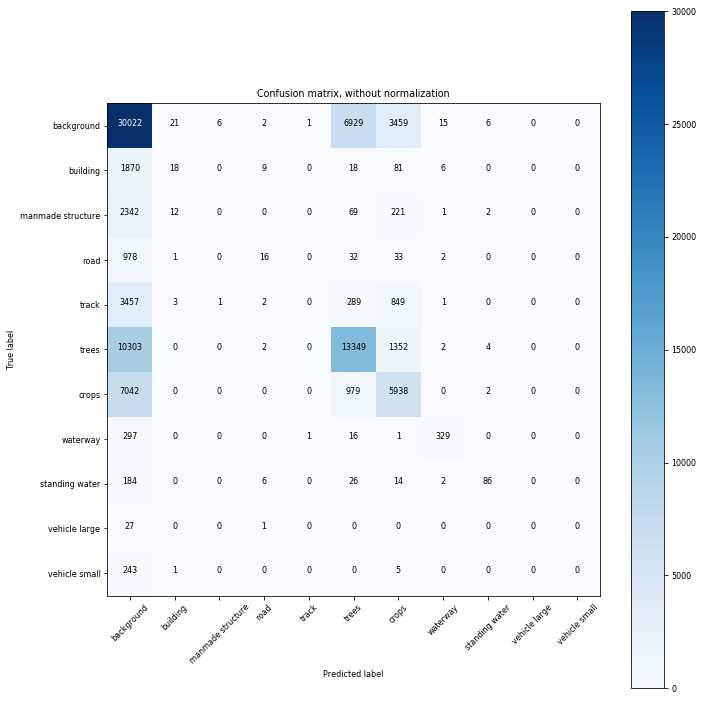

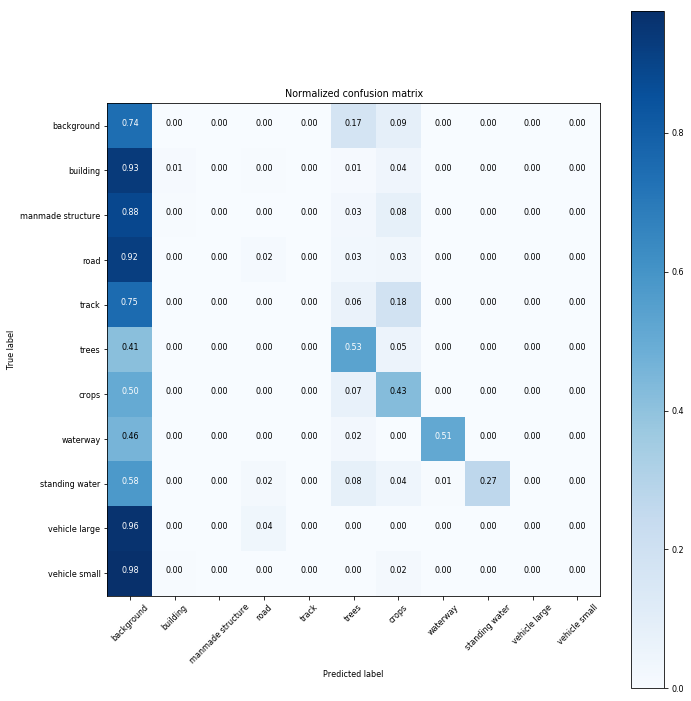

In [127]:
cnf_matrix = confusion_matrix(validateY, validatePre)
print(cnf_matrix)
classname = ['background','building','manmade structure','road','track','trees','crops','waterway','standing water','vehicle large','vehicle small']
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=classname,
                      title='Confusion matrix, without normalization')

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=classname, normalize=True,
                      title='Normalized confusion matrix')

In [52]:
from sklearn.metrics import classification_report

In [130]:

print(classification_report(validateY, validatePre, target_names=classname))

                   precision    recall  f1-score   support

       background       0.53      0.74      0.62     40461
         building       0.32      0.01      0.02      2002
manmade structure       0.00      0.00      0.00      2647
             road       0.42      0.02      0.03      1062
            track       0.00      0.00      0.00      4602
            trees       0.61      0.53      0.57     25012
            crops       0.50      0.43      0.46     13961
         waterway       0.92      0.51      0.66       644
   standing water       0.86      0.27      0.41       318
    vehicle large       0.00      0.00      0.00        28
    vehicle small       0.00      0.00      0.00       249

      avg / total       0.50      0.55      0.51     90986



C:\Users\ssjia\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### down sampling to deal with imbalance  (logit)

In [43]:
downX = downdf.values[:,:20]
downY = downdf.values[:,20]

In [132]:
logregd = linear_model.LogisticRegression(C=1e5)
logregd.fit(downX, downY)
validatePre = logregd.predict(validateX)

Confusion matrix, without normalization
[[ 8384  2443  2000   689  2000 11611  5699  2854  1654  1513  1614]
 [    3   664   100   200    65     7    97   108   166   234   358]
 [   40   625   189   227   120    23   295    83   410   231   404]
 [    3   135    52   236    14     1    48    40   139   191   203]
 [  566   377   406   171   339   461  1188    62   191   360   481]
 [ 3211   154   579   345   633 15292  2259   862  1235   284   158]
 [  598   407  1023   222   739  1012  8346   230   805   359   220]
 [    0     6    14     8     5     0     0   579    29     3     0]
 [    3    11     4    10     4     5     9    17   240     1    14]
 [    0     7     2     6     0     0     0     1     3     5     4]
 [    1    43    11    24     3     0     4     6    12    31   114]]
Normalized confusion matrix
[[0.20721188 0.06037913 0.04943032 0.01702874 0.04943032 0.2869677
  0.14085168 0.07053706 0.04087887 0.03739403 0.03989026]
 [0.0014985  0.33166833 0.04995005 0.0999001  0

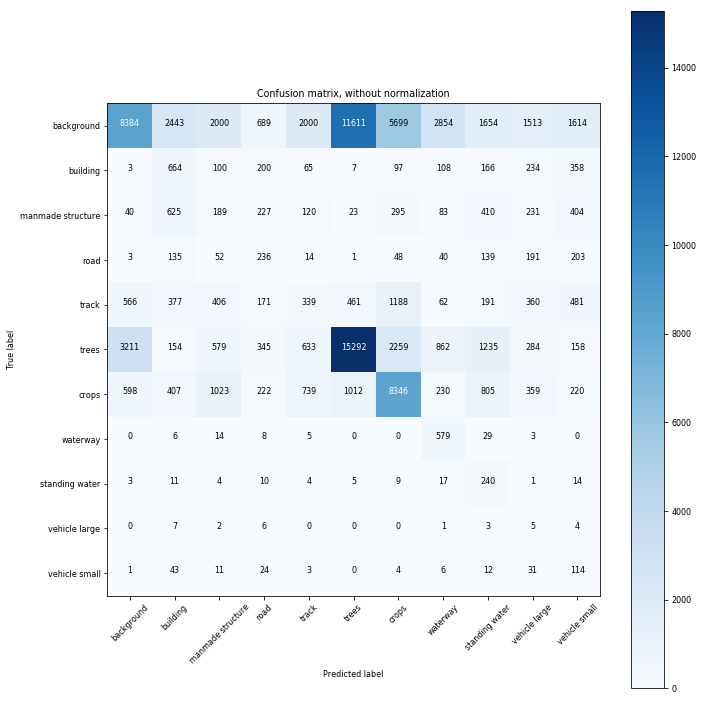

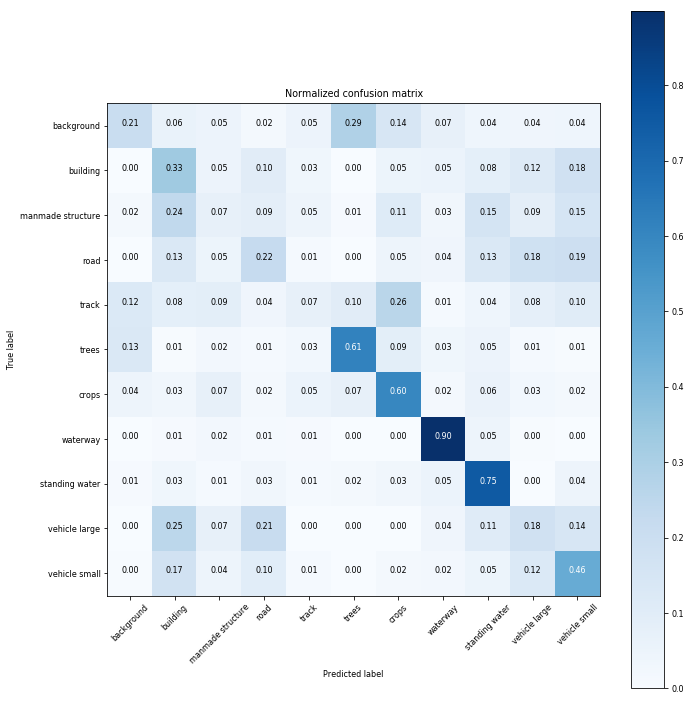

In [133]:
cnf_matrix1 = confusion_matrix(validateY, validatePre)
cnf_matrix1
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix1, classes=classname,
                      title='Confusion matrix, without normalization')

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix1, classes=classname, normalize=True,
                      title='Normalized confusion matrix')

In [134]:

print(classification_report(validateY, validatePre, target_names=classname))

                   precision    recall  f1-score   support

       background       0.65      0.21      0.31     40461
         building       0.14      0.33      0.19      2002
manmade structure       0.04      0.07      0.05      2647
             road       0.11      0.22      0.15      1062
            track       0.09      0.07      0.08      4602
            trees       0.54      0.61      0.57     25012
            crops       0.47      0.60      0.52     13961
         waterway       0.12      0.90      0.21       644
   standing water       0.05      0.75      0.09       318
    vehicle large       0.00      0.18      0.00        28
    vehicle small       0.03      0.46      0.06       249

      avg / total       0.52      0.38      0.39     90986



### oversampling

In [60]:
overX = overdf.values[:,:20]
overY = overdf.values[:,20]

In [136]:
logrego = linear_model.LogisticRegression(C=1e5)
logrego.fit(overX, overY)
validatePre = logrego.predict(validateX)

Confusion matrix, without normalization
[[ 8238  1628  1411   482  2256 11456  6929  2745  1324  2042  1950]
 [    0   565   198   138    58     8    92   122   131   224   466]
 [   29   411   387   179    83    38   279    86   369   292   494]
 [    0    91    44   278     9    11    50    44   125   189   221]
 [  620   226   287   124   363   416  1323    74   133   426   610]
 [ 2786    46   408   303   303 16221  2717   893   876   290   169]
 [  336   116   611   184   513  1058  9540   410   563   341   289]
 [    0     2     0     3     3     0     3   587    35     6     5]
 [    2     3    14     6     2     9    13    17   239     4     9]
 [    0     2     3     5     0     0     1     1     3     7     6]
 [    1    24    11    21     4     0     4     5    10    37   132]]
Normalized confusion matrix
[[0.20360347 0.04023628 0.03487309 0.01191271 0.0557574  0.28313685
  0.17125133 0.06784311 0.03272287 0.05046835 0.04819456]
 [0.         0.28221778 0.0989011  0.06893107 

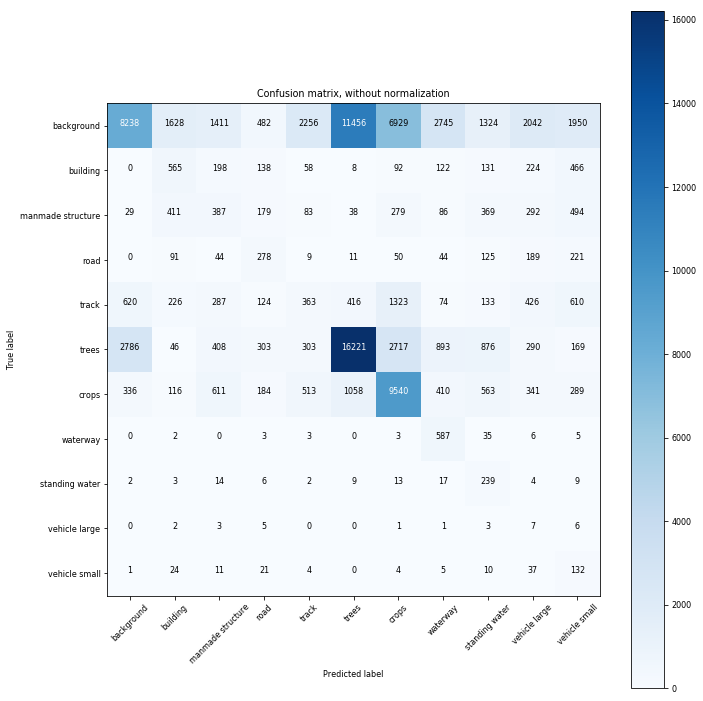

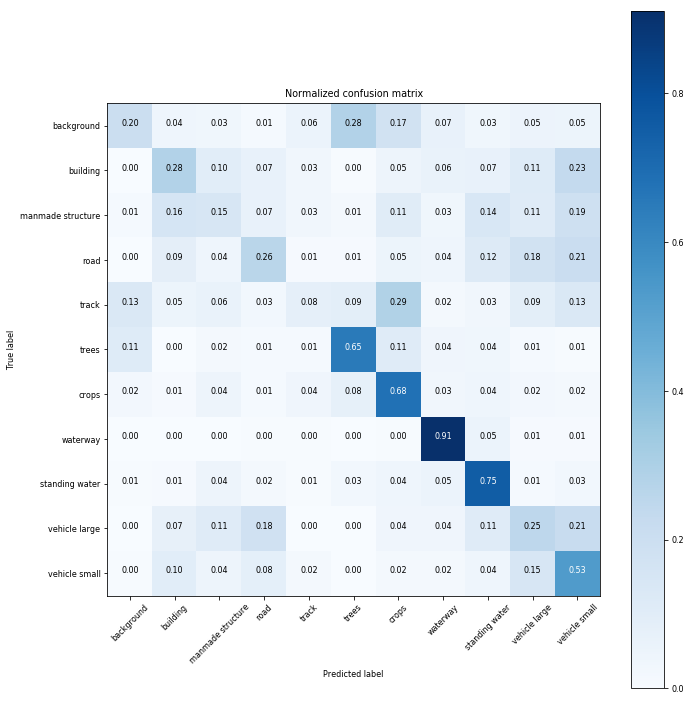

In [137]:
cnf_matrix2 = confusion_matrix(validateY, validatePre)
cnf_matrix2
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix2, classes=classname,
                      title='Confusion matrix, without normalization')

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix2, classes=classname, normalize=True,
                      title='Normalized confusion matrix')

In [138]:
print(classification_report(validateY, validatePre, target_names=classname))

                   precision    recall  f1-score   support

       background       0.69      0.20      0.31     40461
         building       0.18      0.28      0.22      2002
manmade structure       0.11      0.15      0.13      2647
             road       0.16      0.26      0.20      1062
            track       0.10      0.08      0.09      4602
            trees       0.56      0.65      0.60     25012
            crops       0.46      0.68      0.55     13961
         waterway       0.12      0.91      0.21       644
   standing water       0.06      0.75      0.12       318
    vehicle large       0.00      0.25      0.00        28
    vehicle small       0.03      0.53      0.06       249

      avg / total       0.54      0.40      0.41     90986



## method: random forest

### original data

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [49]:

clf = RandomForestClassifier(n_estimators=20, random_state=0)
clf.fit(X, Y)
validatePre = clf.predict(validateX)

Confusion matrix, without normalization
[[31333   253   253    76   276  5489  2729    38     9     0     5]
 [ 1456   284   112    26    34    52    31     3     2     0     2]
 [ 1861   114   177    21    59   153   256     2     2     0     2]
 [  410    39    31   475    29    37    39     0     0     0     2]
 [ 2861    53    66    55   294   466   802     1     2     0     2]
 [ 7883     5    53    10    46 15552  1453     6     4     0     0]
 [ 3046     2    62    11   102   763  9968     2     5     0     0]
 [  171     3     0     1     0    26     8   435     0     0     0]
 [   70     2     8     7     0    65    27     0   139     0     0]
 [   14     1     1     7     2     0     2     0     1     0     0]
 [  175     6     9    39    11     0     3     1     0     0     5]]
Normalized confusion matrix
[[7.74400040e-01 6.25293492e-03 6.25293492e-03 1.87835199e-03
  6.82138355e-03 1.35661501e-01 6.74476657e-02 9.39175997e-04
  2.22436420e-04 0.00000000e+00 1.23575789e-04]


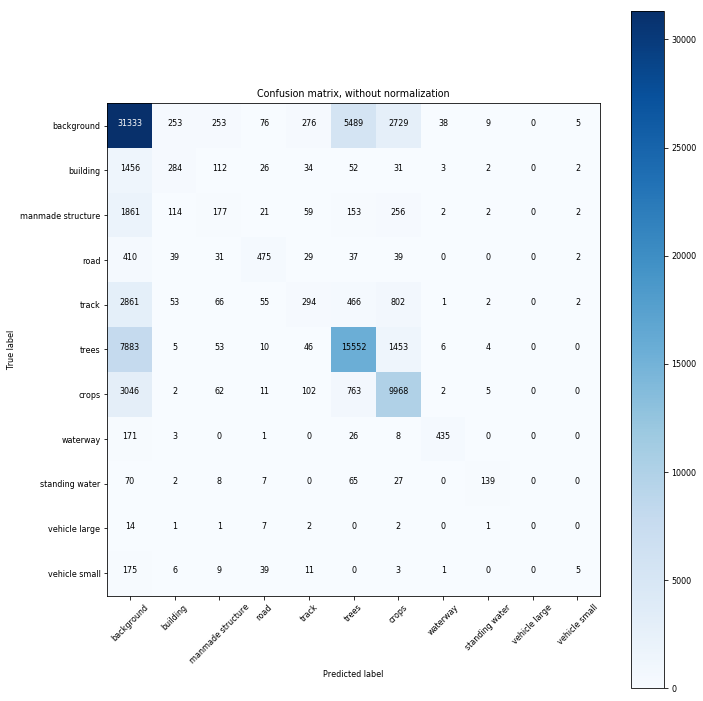

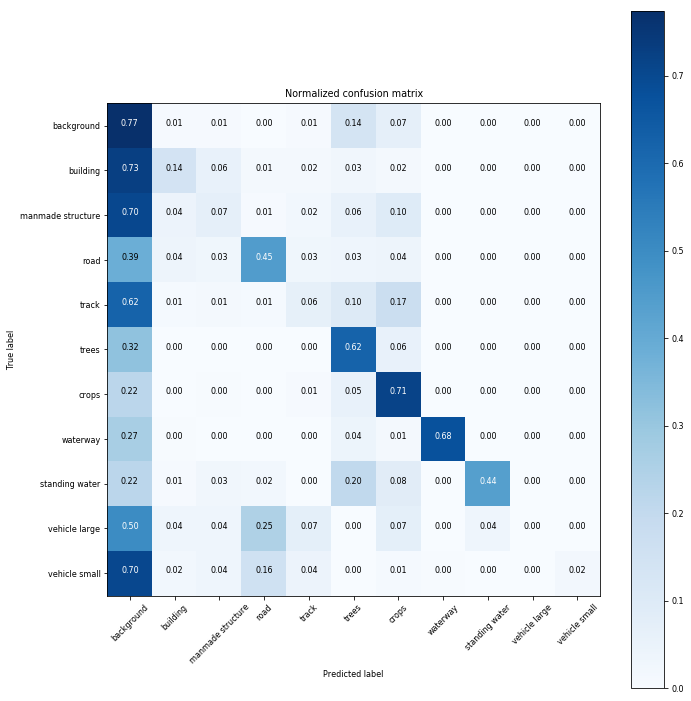

In [50]:
cnf_matrix2 = confusion_matrix(validateY, validatePre)
cnf_matrix2
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix2, classes=classname,
                      title='Confusion matrix, without normalization')

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix2, classes=classname, normalize=True,
                      title='Normalized confusion matrix')

In [53]:
print(classification_report(validateY, validatePre, target_names=classname))

                   precision    recall  f1-score   support

       background       0.64      0.77      0.70     40461
         building       0.37      0.14      0.21      2002
manmade structure       0.23      0.07      0.10      2647
             road       0.65      0.45      0.53      1062
            track       0.34      0.06      0.11      4602
            trees       0.69      0.62      0.65     25012
            crops       0.65      0.71      0.68     13961
         waterway       0.89      0.68      0.77       644
   standing water       0.85      0.44      0.58       318
    vehicle large       0.00      0.00      0.00        28
    vehicle small       0.28      0.02      0.04       249

      avg / total       0.62      0.64      0.62     90986



C:\Users\ssjia\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### downsampling data

In [54]:

clf = RandomForestClassifier(n_estimators=20, random_state=0)
clf.fit(downX, downY)
validatePre = clf.predict(validateX)

Confusion matrix, without normalization
[[11405  2124  2459  1212  3891  8724  5230  1824   961  1180  1451]
 [   67   521   425   226    94    30    70    65    62   180   262]
 [  158   463   579   238   160    43   197    48   215   238   308]
 [   13    88   124   377    36    10    34    15    50   149   166]
 [  727   308   485   258   766   390   833    45   100   339   351]
 [ 4620   432   744   325  1205 12409  2178   564  2206   168   161]
 [ 1066   222  1101   340  2428   976  7008    84   355   134   247]
 [   29    13     5    12     6     6     5   551     3    11     3]
 [    7    14    39    16    11     6     7     6   201     4     7]
 [    0     2     2     2     1     0     1     1     3     4    12]
 [    4    41    26    30     3     1     3     3     9    24   105]]
Normalized confusion matrix
[[0.28187637 0.052495   0.06077457 0.02995477 0.09616668 0.21561504
  0.12926028 0.04508045 0.02375127 0.02916389 0.03586169]
 [0.03346653 0.26023976 0.21228771 0.11288711 

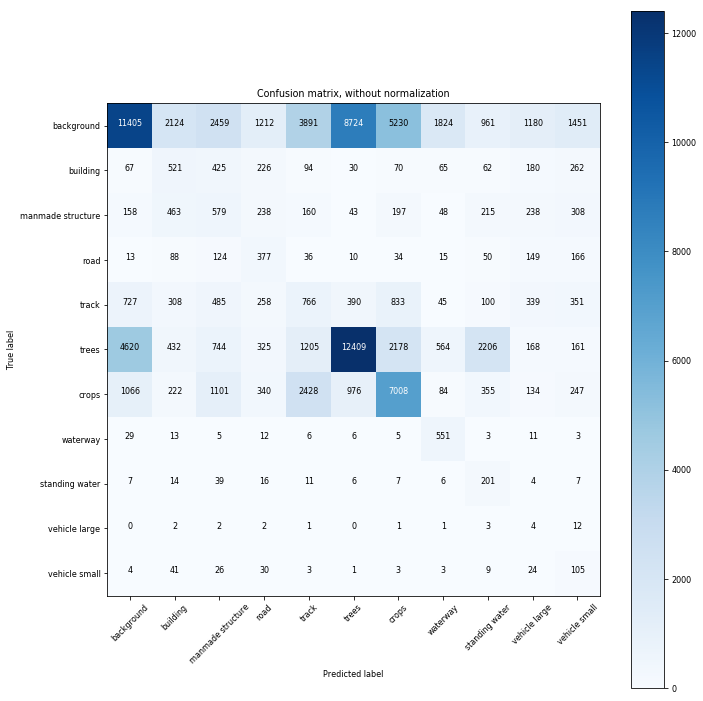

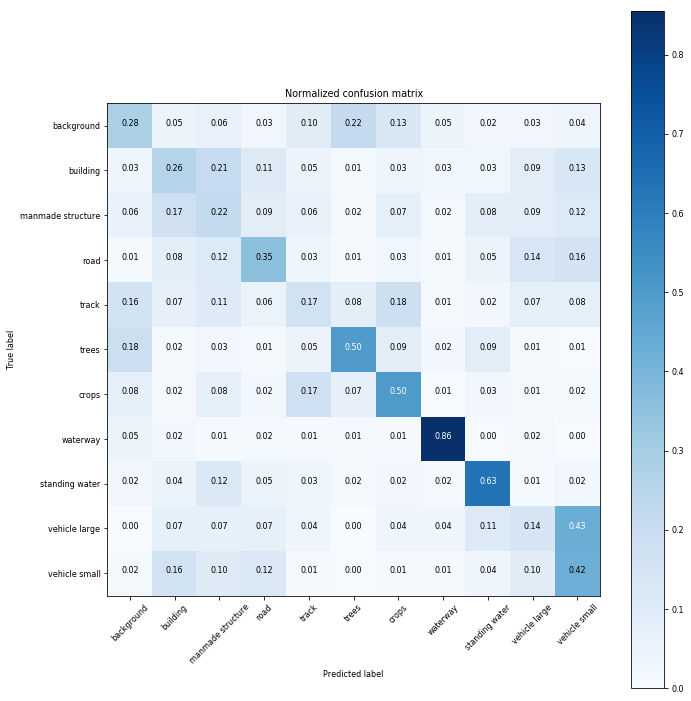

In [55]:
cnf_matrix2 = confusion_matrix(validateY, validatePre)
cnf_matrix2
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix2, classes=classname,
                      title='Confusion matrix, without normalization')

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix2, classes=classname, normalize=True,
                      title='Normalized confusion matrix')

In [56]:
print(classification_report(validateY, validatePre, target_names=classname))

                   precision    recall  f1-score   support

       background       0.63      0.28      0.39     40461
         building       0.12      0.26      0.17      2002
manmade structure       0.10      0.22      0.13      2647
             road       0.12      0.35      0.18      1062
            track       0.09      0.17      0.12      4602
            trees       0.55      0.50      0.52     25012
            crops       0.45      0.50      0.47     13961
         waterway       0.17      0.86      0.29       644
   standing water       0.05      0.63      0.09       318
    vehicle large       0.00      0.14      0.00        28
    vehicle small       0.03      0.42      0.06       249

      avg / total       0.51      0.37      0.41     90986



### oversampling data

In [61]:
clf = RandomForestClassifier(n_estimators=20, random_state=0)
clf.fit(overX, overY)
validatePre = clf.predict(validateX)

Confusion matrix, without normalization
[[28821   504   568   111   656  6303  3430    39    13     1    15]
 [ 1215   408   190    25    70    44    45     3     1     0     1]
 [ 1545   193   311    39    96   154   300     3     3     0     3]
 [  291    38    48   557    45    30    47     0     0     0     6]
 [ 2387   110   132    73   490   473   922     4     4     0     7]
 [ 6790    11   104    19   138 16184  1737    14    14     0     1]
 [ 2157     5   141    17   186   706 10741     2     6     0     0]
 [  164     6     1     4     1    31    10   426     0     0     1]
 [   61     1    11     5     3    54    38     1   144     0     0]
 [   12     0     2     7     1     0     2     1     1     0     2]
 [  135    15    18    46    22     1     3     0     0     0     9]]
Normalized confusion matrix
[[7.12315563e-01 1.24564395e-02 1.40382096e-02 2.74338252e-03
  1.62131435e-02 1.55779640e-01 8.47729913e-02 9.63891154e-04
  3.21297051e-04 2.47151578e-05 3.70727367e-04]


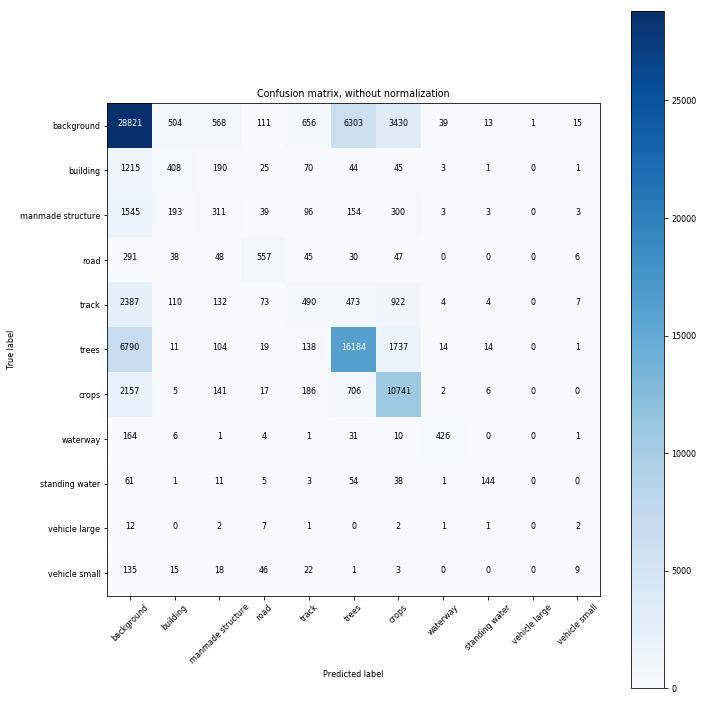

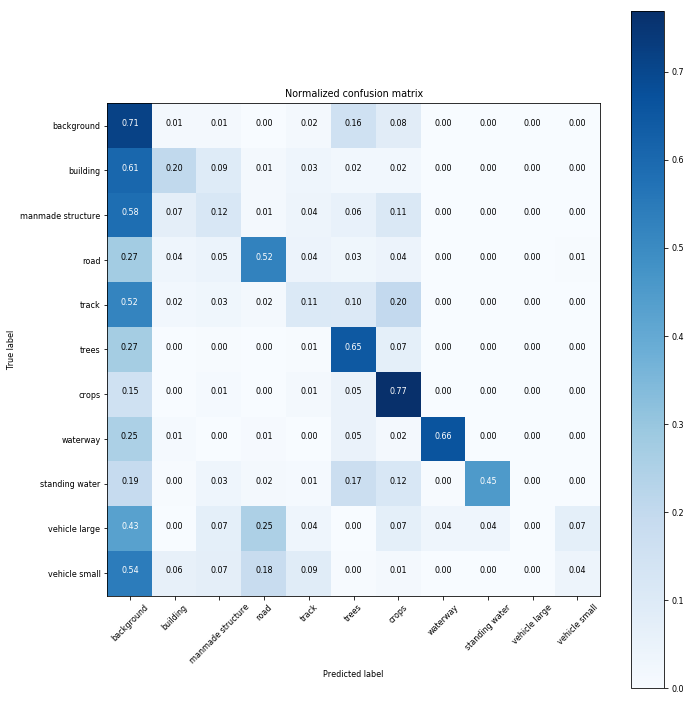

In [62]:
cnf_matrix2 = confusion_matrix(validateY, validatePre)
cnf_matrix2
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix2, classes=classname,
                      title='Confusion matrix, without normalization')

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix2, classes=classname, normalize=True,
                      title='Normalized confusion matrix')

In [63]:
print(classification_report(validateY, validatePre, target_names=classname))

                   precision    recall  f1-score   support

       background       0.66      0.71      0.69     40461
         building       0.32      0.20      0.25      2002
manmade structure       0.20      0.12      0.15      2647
             road       0.62      0.52      0.57      1062
            track       0.29      0.11      0.16      4602
            trees       0.67      0.65      0.66     25012
            crops       0.62      0.77      0.69     13961
         waterway       0.86      0.66      0.75       644
   standing water       0.77      0.45      0.57       318
    vehicle large       0.00      0.00      0.00        28
    vehicle small       0.20      0.04      0.06       249

      avg / total       0.62      0.64      0.62     90986



### Using M shape to resize

In [64]:
myimg = image(sizeto = 'M')
columnname=['I3band1', 'I3band2', 'I3band3',
                            'IAband1','IAband2','IAband3','IAband4',
                            'IAband5','IAband6','IAband7','IAband8',
                            'IMband1','IMband2','IMband3','IMband4',
                            'IMband5','IAband6','IAband7','IAband8',
                            'IP','class']
myimg.get_trainimg_id()
df = pd.DataFrame(columns=columnname)
for imgid in myimg.trainImageIds:
    print(imgid)
    myimg.read_train_oneimg(imgid)
    Imask = myimg.mask
    #plt.imshow(Imask)
    
    Irgbnew = myimg.Irgbnew
    I3band1 = Irgbnew[0].flatten()[:,np.newaxis]
    I3band2 = Irgbnew[1].flatten()[:,np.newaxis]
    I3band3 = Irgbnew[2].flatten()[:,np.newaxis]
    Iall= np.hstack((I3band1,I3band2,I3band3))
    IA =myimg.I16bandAnew
    IM =myimg.I16bandMnew
    IP =myimg.I16bandPnew
    for i in range(8):
        IAband = IA[i].flatten()[:,np.newaxis]
        Iall= np.hstack((Iall,IAband))
    for i in range(8):
        IMband = IM[i].flatten()[:,np.newaxis]
        Iall= np.hstack((Iall,IMband))   
    IPband = IP.flatten()[:,np.newaxis]
    Iall= np.hstack((Iall,IPband))
    Iclass = Imask.flatten()[:,np.newaxis]
    Iall= np.hstack((Iall,Iclass)) 
    df2 = pd.DataFrame(Iall, columns=columnname)
    
    df=df.append(df2, ignore_index=True)
    
df['class'] = df['class'].astype(np.int32)

6040_2_2
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)


C:\Users\ssjia\Anaconda3\envs\py35\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


6120_2_2
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
6120_2_0
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
6090_2_0
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
6040_1_3
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
6040_1_0
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
6100_1_3
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values to range (0,1)
normalizing pixel values t

In [152]:
df["class"].value_counts()

0     10835174
6      3474402
5      2051792
4       558304
1       380727
2       159418
3       154643
7        92870
8        33644
10        6516
9         1093
Name: class, dtype: int64

In [153]:
traindf = df.sample(frac=0.8,random_state=200)
validatedf = df.drop(traindf.index)

In [154]:
validateX = validatedf.values[:,:20]
validateY = validatedf.values[:,20]

In [155]:
X = traindf.values[:,:20]
Y = traindf.values[:,20]

In [156]:
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X, Y)
validatePre = logreg.predict(validateX)

[[1930553    4000       2      65      47   39651  192027     375     367
        0       0]
 [  66747    6237       6     258      85     191    2572      58       6
        0       0]
 [  26629      73       0       2       0     309    4907      15       1
        0       0]
 [  29714      73       0     271       0      66     797      15       1
        0       0]
 [  88839      43       0       2       8    1054   21967       2       2
        0       0]
 [ 289029       6       0       4       0  102205   18904      91      34
        0       0]
 [ 322966       2       0       6       0    3556  368150       0      67
        0       0]
 [   5945      77       0      56       0      22       2   12264       3
        0       0]
 [   3433      34       0     201       0      50     198      44    2820
        0       0]
 [    186       5       0       7       0       4       5       0       5
        0       0]
 [   1235      12       0       4       0       3      45       0     

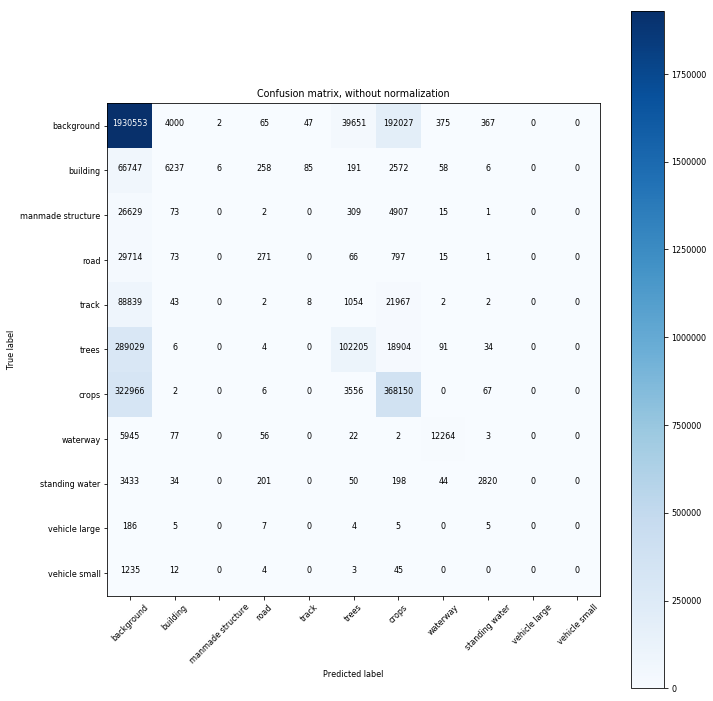

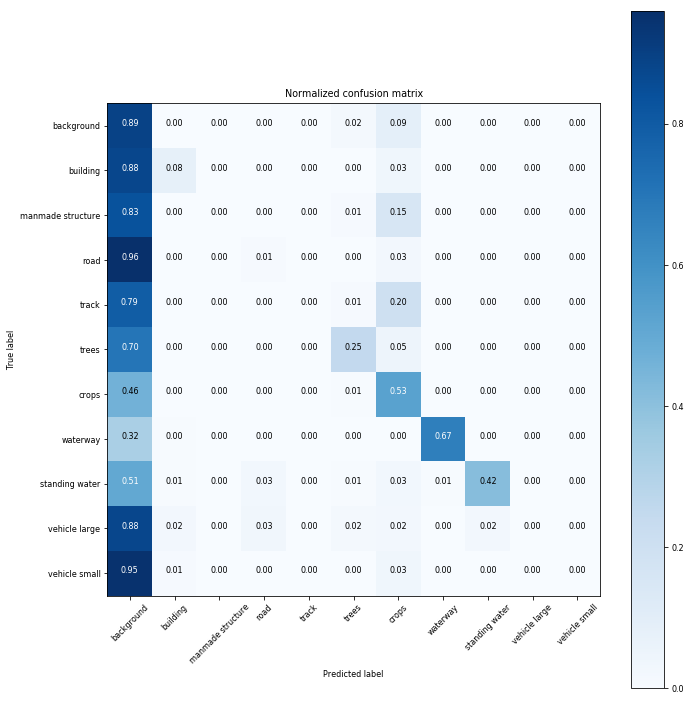

In [157]:
cnf_matrix = confusion_matrix(validateY, validatePre)
print(cnf_matrix)
classname = ['background','building','manmade structure','road','track','trees','crops','waterway','standing water','vehicle large','vehicle small']
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=classname,
                      title='Confusion matrix, without normalization')

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=classname, normalize=True,
                      title='Normalized confusion matrix')

In [158]:
print(classification_report(validateY, validatePre, target_names=classname))

                   precision    recall  f1-score   support

       background       0.70      0.89      0.78   2167087
         building       0.59      0.08      0.14     76160
manmade structure       0.00      0.00      0.00     31936
             road       0.31      0.01      0.02     30937
            track       0.06      0.00      0.00    111917
            trees       0.69      0.25      0.37    410273
            crops       0.60      0.53      0.56    694747
         waterway       0.95      0.67      0.79     18369
   standing water       0.85      0.42      0.56      6780
    vehicle large       0.00      0.00      0.00       212
    vehicle small       0.00      0.00      0.00      1299

      avg / total       0.65      0.68      0.64   3549717



C:\Users\ssjia\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## texture

C:\Users\ssjia\Anaconda3\envs\py35\lib\site-packages\skimage\feature\texture.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):


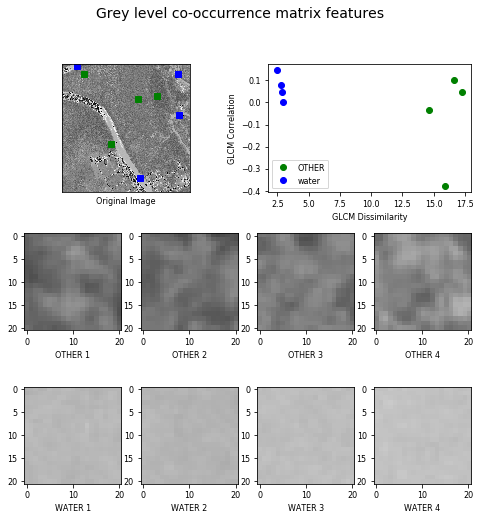

In [160]:
# -*- coding: utf-8 -*-
"""
Created on Thu May  3 01:52:29 2018

@author: ssjiang
"""

import matplotlib.pyplot as plt

from skimage.feature import greycomatrix, greycoprops
from skimage import data
import numpy as np

PATCH_SIZE = 21
def stretch_n(bands, lower_percent=5, higher_percent=95):#normalize
    out = np.zeros_like(bands)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.uint8)
# open the camera image
#image = data.camera()
def stretch_n(bands, lower_percent=5, higher_percent=95):#normalize
    out = np.zeros_like(bands)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)
import tifffile as tiff
#rgb
img_ind = '6070_2_3'
inDir = 'C:/Users/ssjia/project/'
img_filename_3band = inDir+'data/three_band/'+img_ind+'.tif'

from skimage import img_as_float
Irgb = tiff.imread(img_filename_3band)
image1 = np.moveaxis(Irgb,0,2)
image = image1[:,:,0].astype(np.uint8)
#plt.imshow(image.astype(np.uint8))
#plt.show()

# select some patches from grassy areas of the image
grass_locations = [(827,2469), (2064,1278), (895,1978), (249,561)]
grass_patches = []
for loc in grass_locations:
    grass_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])

# select some patches from sky areas of the image
water_locations = [(1304,3055), (253,3035), (2962,2029), (26,377)]
water_patches = []
for loc in water_locations:
    water_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])

# compute some GLCM properties each patch
xs = []
ys = []
for patch in (grass_patches + water_patches):
    glcm = greycomatrix(patch, [5], [0], 256, symmetric=True, normed=True)
    xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(greycoprops(glcm, 'correlation')[0, 0])

# create the figure
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray, interpolation='nearest',
          vmin=0, vmax=255)
for (y, x) in grass_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in water_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(xs[:len(grass_patches)], ys[:len(grass_patches)], 'go',
        label='OTHER')
ax.plot(xs[len(grass_patches):], ys[len(grass_patches):], 'bo',
        label='water')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(grass_patches):
    ax = fig.add_subplot(3, len(grass_patches), len(grass_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, interpolation='nearest',
              vmin=0, vmax=255)
    ax.set_xlabel('OTHER %d' % (i + 1))

for i, patch in enumerate(water_patches):
    ax = fig.add_subplot(3, len(water_patches), len(water_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, interpolation='nearest',
              vmin=0, vmax=255)
    ax.set_xlabel('WATER %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14)
plt.show()

C:\Users\ssjia\Anaconda3\envs\py35\lib\site-packages\skimage\feature\texture.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):


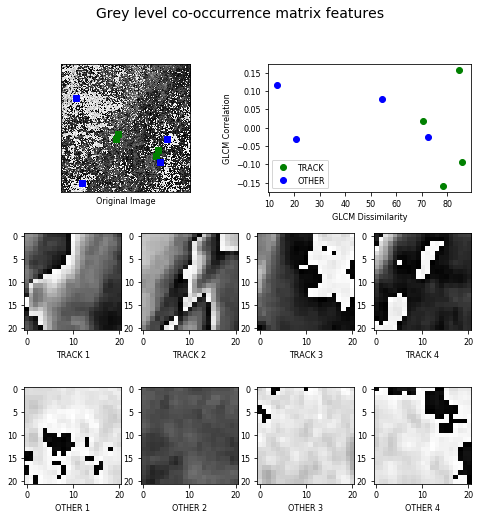

In [161]:
img_ind = '6170_2_4'
inDir = 'C:/Users/ssjia/project/'
img_filename_3band = inDir+'data/three_band/'+img_ind+'.tif'

from skimage import img_as_float
Irgb = tiff.imread(img_filename_3band)
image1 = np.moveaxis(Irgb,0,2)
image = image1[:,:,0].astype(np.uint8)


# select some patches from grassy areas of the image
grass_locations = [(1945,1432), (1825,1484), (2234,2538), (2399,2472)]
grass_patches = []
for loc in grass_locations:
    grass_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])

# select some patches from sky areas of the image
#water_locations = [(1304,3055), (253,3035), (2962,2029), (26,377)]
water_locations = [(1956,2764), (2534,2572), (866,388), (3095,543)]
water_patches = []
for loc in water_locations:
    water_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])

# compute some GLCM properties each patch
xs = []
ys = []
for patch in (grass_patches + water_patches):
    glcm = greycomatrix(patch, [5], [0], 256, symmetric=True, normed=True)
    xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(greycoprops(glcm, 'correlation')[0, 0])

# create the figure
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray, interpolation='nearest',
          vmin=0, vmax=255)
for (y, x) in grass_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in water_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(xs[:len(grass_patches)], ys[:len(grass_patches)], 'go',
        label='TRACK')
ax.plot(xs[len(grass_patches):], ys[len(grass_patches):], 'bo',
        label='OTHER')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(grass_patches):
    ax = fig.add_subplot(3, len(grass_patches), len(grass_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, interpolation='nearest',
              vmin=0, vmax=255)
    ax.set_xlabel('TRACK %d' % (i + 1))

for i, patch in enumerate(water_patches):
    ax = fig.add_subplot(3, len(water_patches), len(water_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, interpolation='nearest',
              vmin=0, vmax=255)
    ax.set_xlabel('OTHER %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14)
plt.show()

## targeting at track,road and stream

In [86]:
from skimage import color
from skimage.feature import greycomatrix, greycoprops

class pathimage():
    def __init__(self, inDir = './data/',sizeto='A'):
        self.N_Cls = 10
        self.traininfo = pd.read_csv(inDir + 'train_wkt_v4.csv')
        self.traincoor = pd.read_csv(inDir + 'grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)#coordinates
        self.threebandloc = inDir + 'three_band/'
        self.sixteenbandloc = inDir + 'sixteen_band/'
        self.trainImageIds = None
        self.patchsize = 21
        self.maxrow = None
        self.maxcol = None
        self.Irgb = None
        self.Irgbnew = None
        self.Irgbpad = None
        self.xmax = None
        self.ymin = None
        self.mask = None
        self.para = sizeto
        self.maskdict = None
        self.glcmdis = None
        self.glcmcor = None
        self.glcmcon = None
        self.glcmhom = None
        self.classind = {'0':'background','1':'building','2':'manmade structure','3':'road',
                          '4':'track','5':'trees','6':'crops','7':'waterway',
                          '8':'standing water','9':'vehicle large','10':'vehicle small'}
        self.classorder = [6,5,1,2,3,4,7,8,9,10]
    def resize_to_resolution(self, para = 'rgb'):
        if self.Irgb.shape[0] == 3: 
            thismode = 'channel_first'
        else:
            thismode = 'channel_last'
        if (para == 'rgb'):#best resolution
            row = self.Irgb.shape[1]
            col = self.Irgb.shape[2]
        if (para == 'A'):#smallest 
            row = self.I16bandA.shape[1]
            col = self.I16bandA.shape[2]
        if (para == 'M'):#medium
            row = self.I16bandM.shape[1]
            col = self.I16bandM.shape[2]
        self.Irgbnew = resize_img(self.Irgb,size =(row,col),mode=thismode)
        return
    def _convert_coordinates_to_raster(self,coords, img_size, xymax):
        # __author__ = visoft
        # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        Xmax, Ymax = xymax
        H, W = img_size
        W1 = 1.0 * W * W / (W + 1)
        H1 = 1.0 * H * H / (H + 1)
        xf = W1 / Xmax
        yf = H1 / Ymax
        coords[:, 1] *= yf
        coords[:, 0] *= xf
        coords_int = np.round(coords).astype(np.int32)
        return coords_int
    def _get_xmax_ymin(self, imgid):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        xmax, ymin = self.traincoor[self.traincoor.ImageId == imgid].iloc[0, 1:].astype(float)
        return (xmax, ymin)
   
    def _get_polygon_list(self,imageId, cType):
        # __author__ = visoft
        # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        df_image = self.traininfo[self.traininfo.ImageId == imageId]
        multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
        polygonList = None
        if len(multipoly_def) > 0:
            assert len(multipoly_def) == 1
            polygonList = wkt_loads(multipoly_def.values[0])
        return polygonList
    
    def _get_and_convert_contours(self,polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        perim_list = []
        interior_list = []
        if polygonList is None:
            return None
        for k in range(len(polygonList)):
            poly = polygonList[k]
            perim = np.array(list(poly.exterior.coords))
            perim_c = self._convert_coordinates_to_raster(perim, raster_img_size, xymax)
            perim_list.append(perim_c)
            for pi in poly.interiors:
                interior = np.array(list(pi.coords))
                interior_c = self._convert_coordinates_to_raster(interior, raster_img_size, xymax)
                interior_list.append(interior_c)
        return perim_list, interior_list
    
    def _plot_mask_from_contours(self,raster_img_size, contours, class_value=1):
        # __author__ = visoft
        # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        #self.mask = np.zeros(raster_img_size, np.uint8)
        if contours is None:
            return
        perim_list, interior_list = contours
        if (class_value == 3 or class_value == 4 or class_value == 7):
            cv2.fillPoly(self.mask, perim_list, 1)
            cv2.fillPoly(self.mask, interior_list, 0)
        else:
            cv2.fillPoly(self.mask, perim_list, 0)
            cv2.fillPoly(self.mask, interior_list, 0)
        return 
    
    def generate_mask_for_image_and_class(self,raster_size, imageId, class_type):
        # __author__ = visoft
        # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        xymax = self._get_xmax_ymin(imageId)
        polygon_list =self. _get_polygon_list(imageId, class_type)
        contours = self._get_and_convert_contours(polygon_list, raster_size, xymax)
        self._plot_mask_from_contours(raster_size, contours, class_type)
        return 
    def reset_imgset(self):
        self.Irgb = None
        self.mask = None
        
    def get_trainimg_id(self):
        self.trainImageIds = self.traininfo.ImageId.unique() #all the training image id labeled
        return
    def _normalize_img(self):
        self.Irgb = normalize_image(self.Irgb)
        return
    def cal_glcm(self):
        for i in range(3):
            img = self.Irgbpad[i]*255
            img = img.astype(np.uint8)
            for row in range(self.Irgbnew.shape[1]):
                for col in range(self.Irgbnew.shape[2]):
                    loc = (row+self.patchsize,col+self.patchsize)
                    patch = img[loc[0]:loc[0] + self.patchsize,loc[1]:loc[1] + self.patchsize]
                    glcm = greycomatrix(patch, [5], [0], 256, symmetric=True, normed=True)
                    self.glcmdis[i,row,col]=greycoprops(glcm, 'dissimilarity')[0, 0]
                    self.glcmcor[i,row,col]=greycoprops(glcm, 'correlation')[0, 0]
                    self.glcmcon[i,row,col]=greycoprops(glcm, 'contrast')[0, 0]
                    self.glcmhom[i,row,col]=greycoprops(glcm, 'homogeneity')[0, 0]
                    
            
        
    def read_train_oneimg(self,imgid):   
        #read rgb       
        self.reset_imgset()
        self.Irgb = tiff.imread(self.threebandloc+imgid+'.tif')#shape(3,3349,3389)
        self.I16bandA = tiff.imread(self.sixteenbandloc+imgid+'_A.tif')#8band
        self.I16bandM = tiff.imread(self.sixteenbandloc+imgid+'_M.tif')#8band
        image1 = np.pad(image,21,'linear_ramp')
        self.maxrow = self.Irgb.shape[1]
        self.maxcol = self.Irgb.shape[2]
        self._normalize_img()
        self.resize_to_resolution(para = self.para)
        raster_img_size = ((self.Irgbnew.shape[1],self.Irgbnew.shape[2]))
        self.mask = np.zeros(raster_img_size, np.uint8)
        self.Irgbpad = np.pad(self.Irgbnew,self.patchsize,'linear_ramp')
        self.glcmdis=np.zeros(self.Irgbnew.shape, np.float32)
        self.glcmcor=np.zeros(self.Irgbnew.shape, np.float32)
        self.glcmcon=np.zeros(self.Irgbnew.shape, np.float32)
        self.glcmhom=np.zeros(self.Irgbnew.shape, np.float32)
        self.cal_glcm()
        #self.generate_mask_for_image_and_class(raster_img_size, imgid, 6)       
        for class_type in self.classorder:
            #print("get mask of type:"+str(class_type))
            self.generate_mask_for_image_and_class(raster_img_size, imgid, class_type)
        return

In [69]:
img_ind = '6170_2_4'
pimg = pathimage()
pimg.read_train_oneimg(img_ind)

normalizing pixel values to range (0,1)


C:\Users\ssjia\Anaconda3\envs\py35\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\ssjia\Anaconda3\envs\py35\lib\site-packages\skimage\feature\texture.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):


In [71]:
columnname=['I3band1', 'I3band2', 'I3band3',
            'Iband1dis','Iband2dis','Iband3dis',
            'Iband1cor','Iband2cor','Iband3cor',
            'Iband1con','Iband2con','Iband3con',
            'Iband1hom','Iband2hom','Iband3hom',
            'class']



I3band1 = pimg.Irgbnew[0].flatten()[:,np.newaxis]
I3band2 = pimg.Irgbnew[1].flatten()[:,np.newaxis]
I3band3 = pimg.Irgbnew[2].flatten()[:,np.newaxis]
Iall= np.hstack((I3band1,I3band2,I3band3))

for i in range(3):
    Ibanddis = pimg.glcmdis[i].flatten()[:,np.newaxis]
    Iall= np.hstack((Iall,Ibanddis))
for i in range(3):
    Ibandcor = pimg.glcmcor[i].flatten()[:,np.newaxis]
    Iall= np.hstack((Iall,Ibandcor))   

for i in range(3):
    Ibandcon = pimg.glcmcon[i].flatten()[:,np.newaxis]
    Iall= np.hstack((Iall,Ibandcon))

for i in range(3):
    Ibandhom = pimg.glcmhom[i].flatten()[:,np.newaxis]
    Iall= np.hstack((Iall,Ibandhom))
    
Imask = pimg.mask.flatten()[:,np.newaxis]
Iall= np.hstack((Iall,Imask))
    
tdf = pd.DataFrame(Iall, columns=columnname)
    
    
    
tdf['class'] = tdf['class'].astype(np.int32)

In [72]:
tdf

I3band1   I3band2   I3band3  Iband1dis  Iband2dis  Iband3dis  \
0      0.289092  0.336363  0.193367        0.0   1.369048   2.761905   
1      0.275449  0.374072  0.195063        0.0   1.407738   2.848214   
2      0.342111  0.371260  0.218133        0.0   1.467262   2.994048   
3      0.277942  0.325833  0.192422        0.0   1.494048   3.038691   
4      0.363594  0.373643  0.209431        0.0   1.502976   3.038691   
5      0.289386  0.342607  0.192740        0.0   1.467262   2.961309   
6      0.192893  0.309257  0.171299        0.0   1.455357   2.934524   
7      0.222067  0.339328  0.179660        0.0   1.458333   2.940476   
8      0.112359  0.257592  0.148615        0.0   1.434524   2.889881   
9      0.281979  0.321892  0.186280        0.0   1.446429   2.907738   
10     0.151076  0.252109  0.157652        0.0   1.422619   2.860119   
11     0.085584  0.223864  0.135630        0.0   1.407738   2.818452   
12     0.163562  0.288187  0.157540        0.0   1.354167   2.723214   
13     0.184927  0.304625  0.169231        0.0   1.282738   2.589286   
14     0.125549  0.259373  0.145427        0.0   1.235119   2.482143   
15     0.126321  0.253441  0.152602        0.0   1.205357   2.404762   
16     0.199293  0.331170  0.178017        0.0   1.181548   2.348214   
17     0.177624  0.267817  0.158464        0.0   1.154762   2.297619   
18     0.175029  0.263481  0.160262        0.0   1.107143   2.178571   
19     0.410192  0.410373  0.233756        0.0   1.050595   2.080357   
20     0.311366  0.324046  0.187885        0.0   1.029762   2.044643   
21     0.339805  0.340994  0.210259        0.0   1.044643   2.080357   
22     0.144108  0.258971  0.152304        0.0   1.080357   2.157738   
23     0.355818  0.358343  0.218636        0.0   1.080357   2.163691   
24     0.227983  0.294517  0.172884        0.0   1.089286   2.157738   
25     0.234625  0.305256  0.175485        0.0   1.047619   2.107143   
26     0.194644  0.282707  0.163081        0.0   1.068452   2.160714   
27     0.276639  0.359290  0.188517        0.0   1.089286   2.190476   
28     0.145901  0.269246  0.150780        0.0   1.127976   2.244048   
29     0.185599  0.294398  0.170865        0.0   1.142857   2.250000   
...         ...       ...       ...        ...        ...        ...   
18060  0.259050  0.314279  0.175459        0.0   0.461310   0.958333   
18061  0.261912  0.317070  0.184757        0.0   0.497024   1.029762   
18062  0.332723  0.349628  0.198237        0.0   0.520833   1.083333   
18063  0.178866  0.304634  0.157308        0.0   0.508929   1.059524   
18064  0.288714  0.366889  0.195257        0.0   0.574405   1.199405   
18065  0.222172  0.297581  0.165424        0.0   0.568452   1.187500   
18066  0.236889  0.301728  0.175182        0.0   0.520833   1.089286   
18067  0.188806  0.288749  0.163096        0.0   0.532738   1.104167   
18068  0.161914  0.268053  0.159642        0.0   0.553571   1.139881   
18069  0.143535  0.281769  0.156944        0.0   0.574405   1.184524   
18070  0.099190  0.195863  0.137014        0.0   0.559524   1.151786   
18071  0.131513  0.248321  0.144869        0.0   0.517857   1.062500   
18072  0.178071  0.289343  0.172709        0.0   0.535714   1.092262   
18073  0.176308  0.304618  0.166603        0.0   0.508929   1.041667   
18074  0.211760  0.297296  0.168342        0.0   0.502976   1.026786   
18075  0.246200  0.297727  0.181533        0.0   0.529762   1.080357   
18076  0.174444  0.303679  0.161847        0.0   0.538690   1.089286   
18077  0.327227  0.329529  0.187851        0.0   0.517857   1.053571   
18078  0.277624  0.318506  0.180022        0.0   0.511905   1.038690   
18079  0.194569  0.280829  0.163363        0.0   0.494048   1.005952   
18080  0.183345  0.286233  0.160080        0.0   0.449405   0.907738   
18081  0.296372  0.325344  0.188234        0.0   0.419643   0.848214   
18082  0.232030  0.318977  0.176776        0.0   0.449405   0.910714   
18083  0.392795  0.368182  0.212822        0.0  

In [73]:
tdf['class'].value_counts()

0    17221
1      869
Name: class, dtype: int64

In [76]:
ttraindf = tdf.sample(frac=0.8,random_state=200)
tvalidatedf = tdf.drop(ttraindf.index)
ttrainX = ttraindf.values[:,:15]
ttrainY = ttraindf.values[:,15]
tvalidateX = tvalidatedf.values[:,:15]
tvalidateY = tvalidatedf.values[:,15]

In [77]:
tvalidateY

array([0., 0., 0., ..., 0., 1., 0.])

In [82]:

clf = RandomForestClassifier(n_estimators=100, random_state=0)

clf.fit(ttrainX, ttrainY)
validatePre = clf.predict(tvalidateX)

In [83]:
tname = ['other','path']

Confusion matrix, without normalization
[[3441   14]
 [ 150   13]]
Normalized confusion matrix
[[0.9959479 0.0040521]
 [0.9202454 0.0797546]]


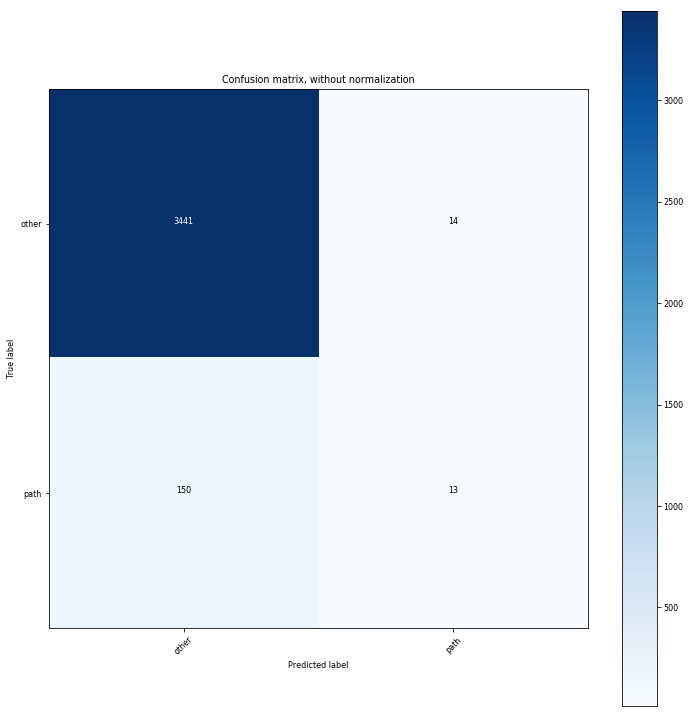

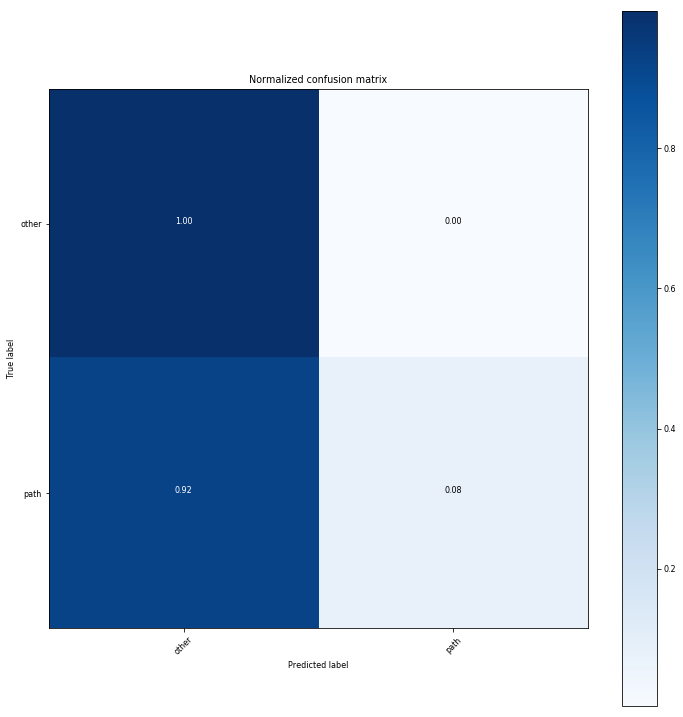

In [84]:
cnf_matrix2 = confusion_matrix(tvalidateY, validatePre)
cnf_matrix2
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix2, classes=tname,
                      title='Confusion matrix, without normalization')

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix2, classes=tname, normalize=True,
                      title='Normalized confusion matrix')

In [89]:
ttrainX.shape

(14472, 15)

In [90]:
rus = RandomUnderSampler(return_indices=True)
X_resampled, Y_resampled, idx_resampled = rus.fit_sample(ttrainX,ttrainY)
Y_resampled=Y_resampled[:,np.newaxis]
Y_resampled.shape

(1412, 1)

In [91]:

downdata = np.hstack((X_resampled,Y_resampled))
print(downdata.shape)
downdf = pd.DataFrame(data=downdata)
downdf.columns= columnname
downdf['class'] = downdf['class'].astype(np.int32)
downdf
downX = downdf.values[:,:15]
downY = downdf.values[:,15]

(1412, 16)


In [92]:
downdf['class'].value_counts()

1    706
0    706
Name: class, dtype: int64

In [102]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)

clf.fit(downX, downY)
validatePre = clf.predict(tvalidateX)

In [103]:
validatePre.shape

(3618,)

Confusion matrix, without normalization
[[2705  750]
 [  40  123]]
Normalized confusion matrix
[[0.7829233  0.2170767 ]
 [0.24539877 0.75460123]]


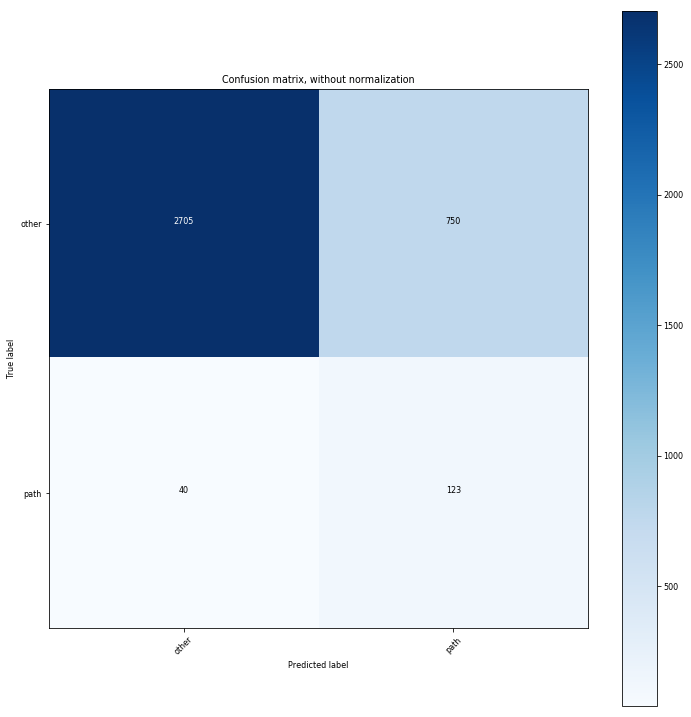

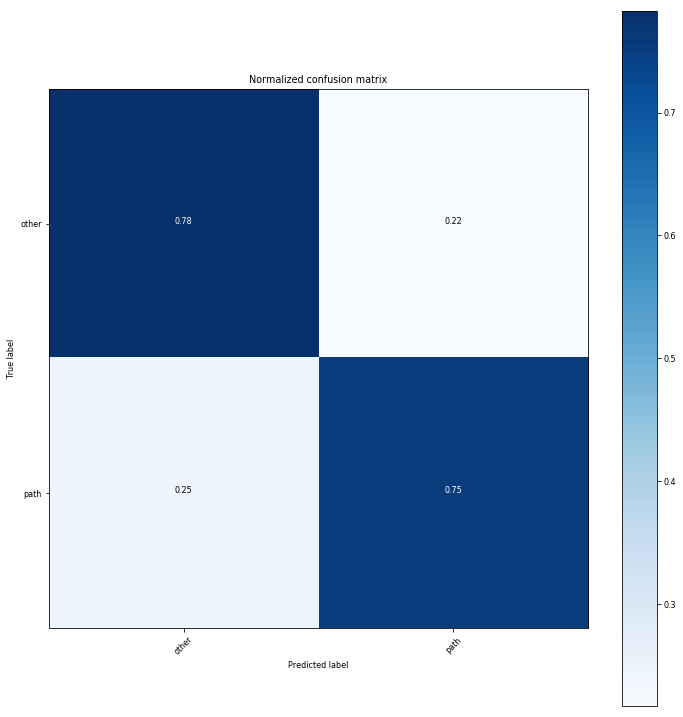

In [104]:
cnf_matrix2 = confusion_matrix(tvalidateY, validatePre)
cnf_matrix2
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix2, classes=tname,
                      title='Confusion matrix, without normalization')

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix2, classes=tname, normalize=True,
                      title='Normalized confusion matrix')

In [105]:
print(classification_report(tvalidateY, validatePre, target_names=tname))

             precision    recall  f1-score   support

      other       0.99      0.78      0.87      3455
       path       0.14      0.75      0.24       163

avg / total       0.95      0.78      0.84      3618



# References

[1] Dataset Dtsl.retrived from https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection/data<br>

[2] SWIR introduction. retrived from http://www.insticc.org/portal/NewsDetails/TabId/246/ArtMID/1130/ArticleID/755/Why-SWIR-Band-in-Remote-Sensing.aspx<br>

[3] World view introduction. retrived from https://www.spaceimagingme.com/downloads/sensors/datasheets/DG_WorldView3_DS_2014.pdf

[4] https://vooban.com/en/tips-articles-geek-stuff/satellite-image-segmentation-workflow-with-u-net/<br>

[5] Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

[6] U-net framework implementation introduction. retrived from https://www.kaggle.com/alijs1/squeezed-this-in-successful-kernel-run/code

[7] U-net in retina application. retrived from https://github.com/orobix/retina-unet

